In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn import utils
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler

import base
import cvae_torch
from importlib import reload
reload(cvae_torch)

<module 'cvae_torch' from '../src\\cvae_torch.py'>

In [27]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

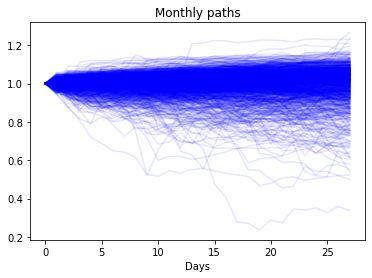

In [28]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 1000,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, test_use = False):
    grid_points_dict = {"M": 28, "W": 5, "Y": 252}
    grid_points = grid_points_dict['M']
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params)

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [29]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params)
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params)
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler_logsig = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler_logsig.fit_transform(train_logsig)

scaler_sig = MinMaxScaler(feature_range=(0.00001, 0.99999))
sig_transformed = scaler_sig.fit_transform(train_sig)

data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 
scaler = scaler_logsig

# data = sig_transformed[1:]   # 1 week forecasting 1 week 
# data_cond = sig_transformed[:-1] 
# scaler = scaler_sig

In [22]:
# Torch
reload(cvae_torch)
BATCH_SIZE = data.shape[0]         # number of data points in each batch
INPUT_DIM = data.shape[-1]     # size of each input
HIDDEN_DIM = 50        # hidden dimension   50
LATENT_DIM = 8         # latent vector dimension   8
CONDITION_DIM = data_cond.shape[-1]      # condition dim
BETA = 0.003
train_iterator, test_iterator = cvae_torch.data_pepare(data,data_cond, None,BATCH_SIZE)
model = cvae_torch.CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, CONDITION_DIM, BETA)
model.prepare(train_iterator, test_iterator)

In [23]:
model.train_all(10000)

Epoch 0, Train Loss: 0.57224, Test Loss: 0.55584
Epoch 1, Train Loss: 0.55717, Test Loss: 0.54087
Epoch 2, Train Loss: 0.54081, Test Loss: 0.52048
Epoch 3, Train Loss: 0.52357, Test Loss: 0.50491
Epoch 4, Train Loss: 0.50670, Test Loss: 0.48853
Epoch 5, Train Loss: 0.48291, Test Loss: 0.47477
Epoch 6, Train Loss: 0.47144, Test Loss: 0.45741
Epoch 7, Train Loss: 0.45837, Test Loss: 0.44414
Epoch 8, Train Loss: 0.44037, Test Loss: 0.42455
Epoch 9, Train Loss: 0.42496, Test Loss: 0.40867
Epoch 10, Train Loss: 0.41043, Test Loss: 0.39458
Epoch 11, Train Loss: 0.39561, Test Loss: 0.37838
Epoch 12, Train Loss: 0.38054, Test Loss: 0.36299
Epoch 13, Train Loss: 0.36464, Test Loss: 0.35119
Epoch 14, Train Loss: 0.35235, Test Loss: 0.33380
Epoch 15, Train Loss: 0.33203, Test Loss: 0.32227
Epoch 16, Train Loss: 0.32204, Test Loss: 0.30868
Epoch 17, Train Loss: 0.30604, Test Loss: 0.29435
Epoch 18, Train Loss: 0.29018, Test Loss: 0.28040
Epoch 19, Train Loss: 0.27686, Test Loss: 0.26670
Epoch 20, 

Epoch 163, Train Loss: 0.03640, Test Loss: 0.03629
Epoch 164, Train Loss: 0.03684, Test Loss: 0.03654
Epoch 165, Train Loss: 0.03671, Test Loss: 0.03616
Epoch 166, Train Loss: 0.03706, Test Loss: 0.03694
Epoch 167, Train Loss: 0.03639, Test Loss: 0.03657
Epoch 168, Train Loss: 0.03617, Test Loss: 0.03654
Epoch 169, Train Loss: 0.03666, Test Loss: 0.03644
Epoch 170, Train Loss: 0.03572, Test Loss: 0.03626
Epoch 171, Train Loss: 0.03656, Test Loss: 0.03652
Epoch 172, Train Loss: 0.03625, Test Loss: 0.03640
Epoch 173, Train Loss: 0.03655, Test Loss: 0.03665
Epoch 174, Train Loss: 0.03593, Test Loss: 0.03628
Epoch 175, Train Loss: 0.03645, Test Loss: 0.03571
Epoch 176, Train Loss: 0.03555, Test Loss: 0.03535
Epoch 177, Train Loss: 0.03609, Test Loss: 0.03594
Epoch 178, Train Loss: 0.03560, Test Loss: 0.03553
Epoch 179, Train Loss: 0.03553, Test Loss: 0.03500
Epoch 180, Train Loss: 0.03528, Test Loss: 0.03559
Epoch 181, Train Loss: 0.03579, Test Loss: 0.03587
Epoch 182, Train Loss: 0.03563,

Epoch 331, Train Loss: 0.03084, Test Loss: 0.03091
Epoch 332, Train Loss: 0.03025, Test Loss: 0.03051
Epoch 333, Train Loss: 0.03068, Test Loss: 0.03070
Epoch 334, Train Loss: 0.02985, Test Loss: 0.03011
Epoch 335, Train Loss: 0.02975, Test Loss: 0.03036
Epoch 336, Train Loss: 0.03019, Test Loss: 0.03055
Epoch 337, Train Loss: 0.02953, Test Loss: 0.02981
Epoch 338, Train Loss: 0.03062, Test Loss: 0.03006
Epoch 339, Train Loss: 0.03013, Test Loss: 0.03028
Epoch 340, Train Loss: 0.03025, Test Loss: 0.03045
Epoch 341, Train Loss: 0.02995, Test Loss: 0.03007
Epoch 342, Train Loss: 0.02988, Test Loss: 0.03011
Epoch 343, Train Loss: 0.03021, Test Loss: 0.03036
Epoch 344, Train Loss: 0.03053, Test Loss: 0.02987
Epoch 345, Train Loss: 0.03018, Test Loss: 0.03019
Epoch 346, Train Loss: 0.03026, Test Loss: 0.03023
Epoch 347, Train Loss: 0.03049, Test Loss: 0.02989
Epoch 348, Train Loss: 0.02985, Test Loss: 0.02942
Epoch 349, Train Loss: 0.02999, Test Loss: 0.03066
Epoch 350, Train Loss: 0.03022,

Epoch 499, Train Loss: 0.02779, Test Loss: 0.02790
Epoch 500, Train Loss: 0.02751, Test Loss: 0.02783
Epoch 501, Train Loss: 0.02745, Test Loss: 0.02759
Epoch 502, Train Loss: 0.02742, Test Loss: 0.02763
Epoch 503, Train Loss: 0.02750, Test Loss: 0.02752
Epoch 504, Train Loss: 0.02761, Test Loss: 0.02783
Epoch 505, Train Loss: 0.02800, Test Loss: 0.02722
Epoch 506, Train Loss: 0.02762, Test Loss: 0.02766
Epoch 507, Train Loss: 0.02745, Test Loss: 0.02756
Epoch 508, Train Loss: 0.02744, Test Loss: 0.02711
Epoch 509, Train Loss: 0.02727, Test Loss: 0.02782
Epoch 510, Train Loss: 0.02772, Test Loss: 0.02754
Epoch 511, Train Loss: 0.02777, Test Loss: 0.02768
Epoch 512, Train Loss: 0.02774, Test Loss: 0.02770
Epoch 513, Train Loss: 0.02761, Test Loss: 0.02789
Epoch 514, Train Loss: 0.02727, Test Loss: 0.02790
Epoch 515, Train Loss: 0.02720, Test Loss: 0.02765
Epoch 516, Train Loss: 0.02710, Test Loss: 0.02730
Epoch 517, Train Loss: 0.02783, Test Loss: 0.02800
Epoch 518, Train Loss: 0.02701,

Epoch 667, Train Loss: 0.02484, Test Loss: 0.02487
Epoch 668, Train Loss: 0.02479, Test Loss: 0.02459
Epoch 669, Train Loss: 0.02464, Test Loss: 0.02526
Epoch 670, Train Loss: 0.02448, Test Loss: 0.02444
Epoch 671, Train Loss: 0.02488, Test Loss: 0.02522
Epoch 672, Train Loss: 0.02484, Test Loss: 0.02513
Epoch 673, Train Loss: 0.02408, Test Loss: 0.02430
Epoch 674, Train Loss: 0.02373, Test Loss: 0.02433
Epoch 675, Train Loss: 0.02511, Test Loss: 0.02492
Epoch 676, Train Loss: 0.02433, Test Loss: 0.02390
Epoch 677, Train Loss: 0.02388, Test Loss: 0.02457
Epoch 678, Train Loss: 0.02505, Test Loss: 0.02438
Epoch 679, Train Loss: 0.02402, Test Loss: 0.02410
Epoch 680, Train Loss: 0.02382, Test Loss: 0.02418
Epoch 681, Train Loss: 0.02433, Test Loss: 0.02421
Epoch 682, Train Loss: 0.02409, Test Loss: 0.02344
Epoch 683, Train Loss: 0.02449, Test Loss: 0.02391
Epoch 684, Train Loss: 0.02454, Test Loss: 0.02362
Epoch 685, Train Loss: 0.02441, Test Loss: 0.02410
Epoch 686, Train Loss: 0.02355,

Epoch 834, Train Loss: 0.01858, Test Loss: 0.01811
Epoch 835, Train Loss: 0.01835, Test Loss: 0.01788
Epoch 836, Train Loss: 0.01833, Test Loss: 0.01797
Epoch 837, Train Loss: 0.01810, Test Loss: 0.01837
Epoch 838, Train Loss: 0.01791, Test Loss: 0.01781
Epoch 839, Train Loss: 0.01828, Test Loss: 0.01830
Epoch 840, Train Loss: 0.01830, Test Loss: 0.01839
Epoch 841, Train Loss: 0.01775, Test Loss: 0.01797
Epoch 842, Train Loss: 0.01816, Test Loss: 0.01844
Epoch 843, Train Loss: 0.01867, Test Loss: 0.01848
Epoch 844, Train Loss: 0.01829, Test Loss: 0.01794
Epoch 845, Train Loss: 0.01815, Test Loss: 0.01814
Epoch 846, Train Loss: 0.01811, Test Loss: 0.01808
Epoch 847, Train Loss: 0.01838, Test Loss: 0.01801
Epoch 848, Train Loss: 0.01794, Test Loss: 0.01806
Epoch 849, Train Loss: 0.01814, Test Loss: 0.01780
Epoch 850, Train Loss: 0.01741, Test Loss: 0.01796
Epoch 851, Train Loss: 0.01781, Test Loss: 0.01820
Epoch 852, Train Loss: 0.01800, Test Loss: 0.01806
Epoch 853, Train Loss: 0.01816,

Epoch 1000, Train Loss: 0.01688, Test Loss: 0.01681
Epoch 1001, Train Loss: 0.01672, Test Loss: 0.01641
Epoch 1002, Train Loss: 0.01647, Test Loss: 0.01666
Epoch 1003, Train Loss: 0.01671, Test Loss: 0.01678
Epoch 1004, Train Loss: 0.01710, Test Loss: 0.01634
Epoch 1005, Train Loss: 0.01683, Test Loss: 0.01668
Epoch 1006, Train Loss: 0.01647, Test Loss: 0.01683
Epoch 1007, Train Loss: 0.01651, Test Loss: 0.01635
Epoch 1008, Train Loss: 0.01677, Test Loss: 0.01666
Epoch 1009, Train Loss: 0.01638, Test Loss: 0.01653
Epoch 1010, Train Loss: 0.01652, Test Loss: 0.01648
Epoch 1011, Train Loss: 0.01676, Test Loss: 0.01684
Epoch 1012, Train Loss: 0.01660, Test Loss: 0.01670
Epoch 1013, Train Loss: 0.01654, Test Loss: 0.01722
Epoch 1014, Train Loss: 0.01667, Test Loss: 0.01704
Epoch 1015, Train Loss: 0.01636, Test Loss: 0.01674
Epoch 1016, Train Loss: 0.01636, Test Loss: 0.01645
Epoch 1017, Train Loss: 0.01690, Test Loss: 0.01661
Epoch 1018, Train Loss: 0.01648, Test Loss: 0.01679
Epoch 1019, 

Epoch 1165, Train Loss: 0.01606, Test Loss: 0.01575
Epoch 1166, Train Loss: 0.01593, Test Loss: 0.01580
Epoch 1167, Train Loss: 0.01583, Test Loss: 0.01559
Epoch 1168, Train Loss: 0.01543, Test Loss: 0.01581
Epoch 1169, Train Loss: 0.01570, Test Loss: 0.01553
Epoch 1170, Train Loss: 0.01554, Test Loss: 0.01613
Epoch 1171, Train Loss: 0.01580, Test Loss: 0.01570
Epoch 1172, Train Loss: 0.01596, Test Loss: 0.01555
Epoch 1173, Train Loss: 0.01589, Test Loss: 0.01564
Epoch 1174, Train Loss: 0.01578, Test Loss: 0.01556
Epoch 1175, Train Loss: 0.01603, Test Loss: 0.01565
Epoch 1176, Train Loss: 0.01566, Test Loss: 0.01565
Epoch 1177, Train Loss: 0.01561, Test Loss: 0.01562
Epoch 1178, Train Loss: 0.01546, Test Loss: 0.01526
Epoch 1179, Train Loss: 0.01591, Test Loss: 0.01550
Epoch 1180, Train Loss: 0.01557, Test Loss: 0.01554
Epoch 1181, Train Loss: 0.01590, Test Loss: 0.01568
Epoch 1182, Train Loss: 0.01552, Test Loss: 0.01570
Epoch 1183, Train Loss: 0.01575, Test Loss: 0.01582
Epoch 1184, 

Epoch 1325, Train Loss: 0.01487, Test Loss: 0.01486
Epoch 1326, Train Loss: 0.01492, Test Loss: 0.01502
Epoch 1327, Train Loss: 0.01499, Test Loss: 0.01490
Epoch 1328, Train Loss: 0.01489, Test Loss: 0.01482
Epoch 1329, Train Loss: 0.01516, Test Loss: 0.01483
Epoch 1330, Train Loss: 0.01525, Test Loss: 0.01480
Epoch 1331, Train Loss: 0.01505, Test Loss: 0.01487
Epoch 1332, Train Loss: 0.01480, Test Loss: 0.01495
Epoch 1333, Train Loss: 0.01514, Test Loss: 0.01479
Epoch 1334, Train Loss: 0.01488, Test Loss: 0.01495
Epoch 1335, Train Loss: 0.01497, Test Loss: 0.01479
Epoch 1336, Train Loss: 0.01501, Test Loss: 0.01485
Epoch 1337, Train Loss: 0.01478, Test Loss: 0.01494
Epoch 1338, Train Loss: 0.01484, Test Loss: 0.01485
Epoch 1339, Train Loss: 0.01498, Test Loss: 0.01487
Epoch 1340, Train Loss: 0.01503, Test Loss: 0.01476
Epoch 1341, Train Loss: 0.01496, Test Loss: 0.01499
Epoch 1342, Train Loss: 0.01492, Test Loss: 0.01493
Epoch 1343, Train Loss: 0.01484, Test Loss: 0.01509
Epoch 1344, 

Epoch 1487, Train Loss: 0.01473, Test Loss: 0.01463
Epoch 1488, Train Loss: 0.01467, Test Loss: 0.01469
Epoch 1489, Train Loss: 0.01480, Test Loss: 0.01442
Epoch 1490, Train Loss: 0.01458, Test Loss: 0.01457
Epoch 1491, Train Loss: 0.01434, Test Loss: 0.01459
Epoch 1492, Train Loss: 0.01466, Test Loss: 0.01445
Epoch 1493, Train Loss: 0.01444, Test Loss: 0.01471
Epoch 1494, Train Loss: 0.01435, Test Loss: 0.01464
Epoch 1495, Train Loss: 0.01453, Test Loss: 0.01451
Epoch 1496, Train Loss: 0.01450, Test Loss: 0.01441
Epoch 1497, Train Loss: 0.01461, Test Loss: 0.01457
Epoch 1498, Train Loss: 0.01446, Test Loss: 0.01461
Epoch 1499, Train Loss: 0.01438, Test Loss: 0.01479
Epoch 1500, Train Loss: 0.01436, Test Loss: 0.01456
Epoch 1501, Train Loss: 0.01449, Test Loss: 0.01449
Epoch 1502, Train Loss: 0.01459, Test Loss: 0.01460
Epoch 1503, Train Loss: 0.01451, Test Loss: 0.01454
Epoch 1504, Train Loss: 0.01475, Test Loss: 0.01445
Epoch 1505, Train Loss: 0.01445, Test Loss: 0.01445
Epoch 1506, 

Epoch 1647, Train Loss: 0.01442, Test Loss: 0.01415
Epoch 1648, Train Loss: 0.01451, Test Loss: 0.01440
Epoch 1649, Train Loss: 0.01422, Test Loss: 0.01412
Epoch 1650, Train Loss: 0.01432, Test Loss: 0.01451
Epoch 1651, Train Loss: 0.01421, Test Loss: 0.01443
Epoch 1652, Train Loss: 0.01415, Test Loss: 0.01433
Epoch 1653, Train Loss: 0.01442, Test Loss: 0.01466
Epoch 1654, Train Loss: 0.01423, Test Loss: 0.01441
Epoch 1655, Train Loss: 0.01447, Test Loss: 0.01435
Epoch 1656, Train Loss: 0.01443, Test Loss: 0.01445
Epoch 1657, Train Loss: 0.01422, Test Loss: 0.01423
Epoch 1658, Train Loss: 0.01446, Test Loss: 0.01436
Epoch 1659, Train Loss: 0.01428, Test Loss: 0.01429
Epoch 1660, Train Loss: 0.01437, Test Loss: 0.01454
Epoch 1661, Train Loss: 0.01458, Test Loss: 0.01431
Epoch 1662, Train Loss: 0.01436, Test Loss: 0.01426
Epoch 1663, Train Loss: 0.01453, Test Loss: 0.01444
Epoch 1664, Train Loss: 0.01445, Test Loss: 0.01441
Epoch 1665, Train Loss: 0.01429, Test Loss: 0.01444
Epoch 1666, 

Epoch 1805, Train Loss: 0.01427, Test Loss: 0.01436
Epoch 1806, Train Loss: 0.01433, Test Loss: 0.01422
Epoch 1807, Train Loss: 0.01426, Test Loss: 0.01426
Epoch 1808, Train Loss: 0.01414, Test Loss: 0.01420
Epoch 1809, Train Loss: 0.01452, Test Loss: 0.01392
Epoch 1810, Train Loss: 0.01408, Test Loss: 0.01411
Epoch 1811, Train Loss: 0.01421, Test Loss: 0.01417
Epoch 1812, Train Loss: 0.01436, Test Loss: 0.01435
Epoch 1813, Train Loss: 0.01426, Test Loss: 0.01428
Epoch 1814, Train Loss: 0.01423, Test Loss: 0.01420
Epoch 1815, Train Loss: 0.01443, Test Loss: 0.01429
Epoch 1816, Train Loss: 0.01415, Test Loss: 0.01395
Epoch 1817, Train Loss: 0.01413, Test Loss: 0.01414
Epoch 1818, Train Loss: 0.01431, Test Loss: 0.01422
Epoch 1819, Train Loss: 0.01424, Test Loss: 0.01423
Epoch 1820, Train Loss: 0.01417, Test Loss: 0.01413
Epoch 1821, Train Loss: 0.01417, Test Loss: 0.01445
Epoch 1822, Train Loss: 0.01404, Test Loss: 0.01416
Epoch 1823, Train Loss: 0.01411, Test Loss: 0.01417
Epoch 1824, 

Epoch 1965, Train Loss: 0.01406, Test Loss: 0.01428
Epoch 1966, Train Loss: 0.01409, Test Loss: 0.01398
Epoch 1967, Train Loss: 0.01421, Test Loss: 0.01412
Epoch 1968, Train Loss: 0.01429, Test Loss: 0.01423
Epoch 1969, Train Loss: 0.01414, Test Loss: 0.01386
Epoch 1970, Train Loss: 0.01416, Test Loss: 0.01397
Epoch 1971, Train Loss: 0.01419, Test Loss: 0.01427
Epoch 1972, Train Loss: 0.01417, Test Loss: 0.01424
Epoch 1973, Train Loss: 0.01429, Test Loss: 0.01415
Epoch 1974, Train Loss: 0.01431, Test Loss: 0.01419
Epoch 1975, Train Loss: 0.01422, Test Loss: 0.01423
Epoch 1976, Train Loss: 0.01424, Test Loss: 0.01403
Epoch 1977, Train Loss: 0.01409, Test Loss: 0.01413
Epoch 1978, Train Loss: 0.01398, Test Loss: 0.01418
Epoch 1979, Train Loss: 0.01409, Test Loss: 0.01396
Epoch 1980, Train Loss: 0.01413, Test Loss: 0.01408
Epoch 1981, Train Loss: 0.01415, Test Loss: 0.01395
Epoch 1982, Train Loss: 0.01378, Test Loss: 0.01405
Epoch 1983, Train Loss: 0.01401, Test Loss: 0.01404
Epoch 1984, 

Epoch 2123, Train Loss: 0.01400, Test Loss: 0.01408
Epoch 2124, Train Loss: 0.01401, Test Loss: 0.01384
Epoch 2125, Train Loss: 0.01383, Test Loss: 0.01395
Epoch 2126, Train Loss: 0.01396, Test Loss: 0.01397
Epoch 2127, Train Loss: 0.01392, Test Loss: 0.01425
Epoch 2128, Train Loss: 0.01390, Test Loss: 0.01392
Epoch 2129, Train Loss: 0.01388, Test Loss: 0.01398
Epoch 2130, Train Loss: 0.01429, Test Loss: 0.01395
Epoch 2131, Train Loss: 0.01394, Test Loss: 0.01391
Epoch 2132, Train Loss: 0.01389, Test Loss: 0.01408
Epoch 2133, Train Loss: 0.01395, Test Loss: 0.01382
Epoch 2134, Train Loss: 0.01382, Test Loss: 0.01399
Epoch 2135, Train Loss: 0.01394, Test Loss: 0.01408
Epoch 2136, Train Loss: 0.01385, Test Loss: 0.01407
Epoch 2137, Train Loss: 0.01397, Test Loss: 0.01414
Epoch 2138, Train Loss: 0.01387, Test Loss: 0.01420
Epoch 2139, Train Loss: 0.01404, Test Loss: 0.01380
Epoch 2140, Train Loss: 0.01387, Test Loss: 0.01405
Epoch 2141, Train Loss: 0.01404, Test Loss: 0.01407
Epoch 2142, 

Epoch 2282, Train Loss: 0.01398, Test Loss: 0.01383
Epoch 2283, Train Loss: 0.01392, Test Loss: 0.01376
Epoch 2284, Train Loss: 0.01380, Test Loss: 0.01402
Epoch 2285, Train Loss: 0.01378, Test Loss: 0.01385
Epoch 2286, Train Loss: 0.01392, Test Loss: 0.01425
Epoch 2287, Train Loss: 0.01404, Test Loss: 0.01392
Epoch 2288, Train Loss: 0.01390, Test Loss: 0.01403
Epoch 2289, Train Loss: 0.01393, Test Loss: 0.01403
Epoch 2290, Train Loss: 0.01385, Test Loss: 0.01386
Epoch 2291, Train Loss: 0.01375, Test Loss: 0.01385
Epoch 2292, Train Loss: 0.01371, Test Loss: 0.01398
Epoch 2293, Train Loss: 0.01403, Test Loss: 0.01378
Epoch 2294, Train Loss: 0.01389, Test Loss: 0.01407
Epoch 2295, Train Loss: 0.01381, Test Loss: 0.01385
Epoch 2296, Train Loss: 0.01376, Test Loss: 0.01379
Epoch 2297, Train Loss: 0.01393, Test Loss: 0.01383
Epoch 2298, Train Loss: 0.01399, Test Loss: 0.01388
Epoch 2299, Train Loss: 0.01410, Test Loss: 0.01380
Epoch 2300, Train Loss: 0.01392, Test Loss: 0.01406
Epoch 2301, 

Epoch 2440, Train Loss: 0.01370, Test Loss: 0.01366
Epoch 2441, Train Loss: 0.01374, Test Loss: 0.01388
Epoch 2442, Train Loss: 0.01364, Test Loss: 0.01382
Epoch 2443, Train Loss: 0.01386, Test Loss: 0.01390
Epoch 2444, Train Loss: 0.01383, Test Loss: 0.01364
Epoch 2445, Train Loss: 0.01384, Test Loss: 0.01383
Epoch 2446, Train Loss: 0.01386, Test Loss: 0.01371
Epoch 2447, Train Loss: 0.01391, Test Loss: 0.01381
Epoch 2448, Train Loss: 0.01375, Test Loss: 0.01376
Epoch 2449, Train Loss: 0.01400, Test Loss: 0.01410
Epoch 2450, Train Loss: 0.01365, Test Loss: 0.01389
Epoch 2451, Train Loss: 0.01392, Test Loss: 0.01367
Epoch 2452, Train Loss: 0.01369, Test Loss: 0.01372
Epoch 2453, Train Loss: 0.01359, Test Loss: 0.01388
Epoch 2454, Train Loss: 0.01384, Test Loss: 0.01380
Epoch 2455, Train Loss: 0.01375, Test Loss: 0.01393
Epoch 2456, Train Loss: 0.01391, Test Loss: 0.01377
Epoch 2457, Train Loss: 0.01404, Test Loss: 0.01382
Epoch 2458, Train Loss: 0.01383, Test Loss: 0.01374
Epoch 2459, 

Epoch 2602, Train Loss: 0.01390, Test Loss: 0.01376
Epoch 2603, Train Loss: 0.01336, Test Loss: 0.01367
Epoch 2604, Train Loss: 0.01369, Test Loss: 0.01362
Epoch 2605, Train Loss: 0.01382, Test Loss: 0.01362
Epoch 2606, Train Loss: 0.01343, Test Loss: 0.01358
Epoch 2607, Train Loss: 0.01390, Test Loss: 0.01361
Epoch 2608, Train Loss: 0.01362, Test Loss: 0.01355
Epoch 2609, Train Loss: 0.01370, Test Loss: 0.01371
Epoch 2610, Train Loss: 0.01362, Test Loss: 0.01367
Epoch 2611, Train Loss: 0.01363, Test Loss: 0.01357
Epoch 2612, Train Loss: 0.01371, Test Loss: 0.01362
Epoch 2613, Train Loss: 0.01375, Test Loss: 0.01369
Epoch 2614, Train Loss: 0.01392, Test Loss: 0.01383
Epoch 2615, Train Loss: 0.01366, Test Loss: 0.01361
Epoch 2616, Train Loss: 0.01361, Test Loss: 0.01376
Epoch 2617, Train Loss: 0.01371, Test Loss: 0.01390
Epoch 2618, Train Loss: 0.01371, Test Loss: 0.01371
Epoch 2619, Train Loss: 0.01383, Test Loss: 0.01375
Epoch 2620, Train Loss: 0.01376, Test Loss: 0.01344
Epoch 2621, 

Epoch 2760, Train Loss: 0.01374, Test Loss: 0.01366
Epoch 2761, Train Loss: 0.01358, Test Loss: 0.01350
Epoch 2762, Train Loss: 0.01376, Test Loss: 0.01357
Epoch 2763, Train Loss: 0.01373, Test Loss: 0.01336
Epoch 2764, Train Loss: 0.01377, Test Loss: 0.01342
Epoch 2765, Train Loss: 0.01347, Test Loss: 0.01367
Epoch 2766, Train Loss: 0.01345, Test Loss: 0.01361
Epoch 2767, Train Loss: 0.01340, Test Loss: 0.01351
Epoch 2768, Train Loss: 0.01366, Test Loss: 0.01353
Epoch 2769, Train Loss: 0.01338, Test Loss: 0.01372
Epoch 2770, Train Loss: 0.01357, Test Loss: 0.01336
Epoch 2771, Train Loss: 0.01350, Test Loss: 0.01340
Epoch 2772, Train Loss: 0.01345, Test Loss: 0.01332
Epoch 2773, Train Loss: 0.01361, Test Loss: 0.01368
Epoch 2774, Train Loss: 0.01361, Test Loss: 0.01354
Epoch 2775, Train Loss: 0.01365, Test Loss: 0.01352
Epoch 2776, Train Loss: 0.01361, Test Loss: 0.01341
Epoch 2777, Train Loss: 0.01350, Test Loss: 0.01362
Epoch 2778, Train Loss: 0.01352, Test Loss: 0.01374
Epoch 2779, 

Epoch 2918, Train Loss: 0.01268, Test Loss: 0.01233
Epoch 2919, Train Loss: 0.01260, Test Loss: 0.01242
Epoch 2920, Train Loss: 0.01252, Test Loss: 0.01206
Epoch 2921, Train Loss: 0.01261, Test Loss: 0.01253
Epoch 2922, Train Loss: 0.01217, Test Loss: 0.01223
Epoch 2923, Train Loss: 0.01202, Test Loss: 0.01232
Epoch 2924, Train Loss: 0.01199, Test Loss: 0.01211
Epoch 2925, Train Loss: 0.01260, Test Loss: 0.01203
Epoch 2926, Train Loss: 0.01232, Test Loss: 0.01262
Epoch 2927, Train Loss: 0.01234, Test Loss: 0.01235
Epoch 2928, Train Loss: 0.01263, Test Loss: 0.01230
Epoch 2929, Train Loss: 0.01233, Test Loss: 0.01186
Epoch 2930, Train Loss: 0.01249, Test Loss: 0.01242
Epoch 2931, Train Loss: 0.01220, Test Loss: 0.01227
Epoch 2932, Train Loss: 0.01231, Test Loss: 0.01245
Epoch 2933, Train Loss: 0.01213, Test Loss: 0.01217
Epoch 2934, Train Loss: 0.01219, Test Loss: 0.01190
Epoch 2935, Train Loss: 0.01189, Test Loss: 0.01188
Epoch 2936, Train Loss: 0.01218, Test Loss: 0.01196
Epoch 2937, 

Epoch 3084, Train Loss: 0.00986, Test Loss: 0.01012
Epoch 3085, Train Loss: 0.00981, Test Loss: 0.01014
Epoch 3086, Train Loss: 0.00990, Test Loss: 0.00974
Epoch 3087, Train Loss: 0.01000, Test Loss: 0.00971
Epoch 3088, Train Loss: 0.00975, Test Loss: 0.01007
Epoch 3089, Train Loss: 0.00986, Test Loss: 0.00996
Epoch 3090, Train Loss: 0.00971, Test Loss: 0.01005
Epoch 3091, Train Loss: 0.00995, Test Loss: 0.01005
Epoch 3092, Train Loss: 0.01005, Test Loss: 0.01008
Epoch 3093, Train Loss: 0.00975, Test Loss: 0.00990
Epoch 3094, Train Loss: 0.00999, Test Loss: 0.00986
Epoch 3095, Train Loss: 0.00991, Test Loss: 0.00993
Epoch 3096, Train Loss: 0.00976, Test Loss: 0.01008
Epoch 3097, Train Loss: 0.00975, Test Loss: 0.00958
Epoch 3098, Train Loss: 0.00988, Test Loss: 0.00979
Epoch 3099, Train Loss: 0.00999, Test Loss: 0.00996
Epoch 3100, Train Loss: 0.00981, Test Loss: 0.00972
Epoch 3101, Train Loss: 0.00979, Test Loss: 0.01000
Epoch 3102, Train Loss: 0.00981, Test Loss: 0.00974
Epoch 3103, 

Epoch 3251, Train Loss: 0.00971, Test Loss: 0.00981
Epoch 3252, Train Loss: 0.00979, Test Loss: 0.00945
Epoch 3253, Train Loss: 0.00930, Test Loss: 0.00952
Epoch 3254, Train Loss: 0.00945, Test Loss: 0.00948
Epoch 3255, Train Loss: 0.00954, Test Loss: 0.00970
Epoch 3256, Train Loss: 0.00953, Test Loss: 0.00986
Epoch 3257, Train Loss: 0.00973, Test Loss: 0.00961
Epoch 3258, Train Loss: 0.00965, Test Loss: 0.00952
Epoch 3259, Train Loss: 0.00961, Test Loss: 0.00937
Epoch 3260, Train Loss: 0.00966, Test Loss: 0.00949
Epoch 3261, Train Loss: 0.00951, Test Loss: 0.00930
Epoch 3262, Train Loss: 0.00973, Test Loss: 0.00935
Epoch 3263, Train Loss: 0.00974, Test Loss: 0.00958
Epoch 3264, Train Loss: 0.00976, Test Loss: 0.00943
Epoch 3265, Train Loss: 0.00957, Test Loss: 0.00964
Epoch 3266, Train Loss: 0.00970, Test Loss: 0.00975
Epoch 3267, Train Loss: 0.00932, Test Loss: 0.00988
Epoch 3268, Train Loss: 0.00946, Test Loss: 0.00938
Epoch 3269, Train Loss: 0.00952, Test Loss: 0.00966
Epoch 3270, 

Epoch 3409, Train Loss: 0.00947, Test Loss: 0.00918
Epoch 3410, Train Loss: 0.00924, Test Loss: 0.00941
Epoch 3411, Train Loss: 0.00927, Test Loss: 0.00914
Epoch 3412, Train Loss: 0.00904, Test Loss: 0.00931
Epoch 3413, Train Loss: 0.00940, Test Loss: 0.00915
Epoch 3414, Train Loss: 0.00929, Test Loss: 0.00928
Epoch 3415, Train Loss: 0.00963, Test Loss: 0.00904
Epoch 3416, Train Loss: 0.00928, Test Loss: 0.00916
Epoch 3417, Train Loss: 0.00933, Test Loss: 0.00937
Epoch 3418, Train Loss: 0.00924, Test Loss: 0.00930
Epoch 3419, Train Loss: 0.00908, Test Loss: 0.00920
Epoch 3420, Train Loss: 0.00929, Test Loss: 0.00931
Epoch 3421, Train Loss: 0.00937, Test Loss: 0.00907
Epoch 3422, Train Loss: 0.00905, Test Loss: 0.00902
Epoch 3423, Train Loss: 0.00930, Test Loss: 0.00921
Epoch 3424, Train Loss: 0.00929, Test Loss: 0.00940
Epoch 3425, Train Loss: 0.00932, Test Loss: 0.00932
Epoch 3426, Train Loss: 0.00915, Test Loss: 0.00935
Epoch 3427, Train Loss: 0.00941, Test Loss: 0.00947
Epoch 3428, 

Epoch 3567, Train Loss: 0.00899, Test Loss: 0.00926
Epoch 3568, Train Loss: 0.00926, Test Loss: 0.00929
Epoch 3569, Train Loss: 0.00921, Test Loss: 0.00898
Epoch 3570, Train Loss: 0.00915, Test Loss: 0.00923
Epoch 3571, Train Loss: 0.00928, Test Loss: 0.00925
Epoch 3572, Train Loss: 0.00899, Test Loss: 0.00914
Epoch 3573, Train Loss: 0.00896, Test Loss: 0.00930
Epoch 3574, Train Loss: 0.00938, Test Loss: 0.00921
Epoch 3575, Train Loss: 0.00956, Test Loss: 0.00913
Epoch 3576, Train Loss: 0.00939, Test Loss: 0.00927
Epoch 3577, Train Loss: 0.00910, Test Loss: 0.00949
Epoch 3578, Train Loss: 0.00917, Test Loss: 0.00902
Epoch 3579, Train Loss: 0.00904, Test Loss: 0.00914
Epoch 3580, Train Loss: 0.00891, Test Loss: 0.00926
Epoch 3581, Train Loss: 0.00943, Test Loss: 0.00915
Epoch 3582, Train Loss: 0.00898, Test Loss: 0.00934
Epoch 3583, Train Loss: 0.00904, Test Loss: 0.00932
Epoch 3584, Train Loss: 0.00917, Test Loss: 0.00904
Epoch 3585, Train Loss: 0.00897, Test Loss: 0.00922
Epoch 3586, 

Epoch 3731, Train Loss: 0.00882, Test Loss: 0.00916
Epoch 3732, Train Loss: 0.00896, Test Loss: 0.00893
Epoch 3733, Train Loss: 0.00912, Test Loss: 0.00878
Epoch 3734, Train Loss: 0.00894, Test Loss: 0.00885
Epoch 3735, Train Loss: 0.00873, Test Loss: 0.00892
Epoch 3736, Train Loss: 0.00896, Test Loss: 0.00881
Epoch 3737, Train Loss: 0.00901, Test Loss: 0.00893
Epoch 3738, Train Loss: 0.00901, Test Loss: 0.00898
Epoch 3739, Train Loss: 0.00895, Test Loss: 0.00887
Epoch 3740, Train Loss: 0.00881, Test Loss: 0.00890
Epoch 3741, Train Loss: 0.00898, Test Loss: 0.00903
Epoch 3742, Train Loss: 0.00878, Test Loss: 0.00886
Epoch 3743, Train Loss: 0.00896, Test Loss: 0.00902
Epoch 3744, Train Loss: 0.00907, Test Loss: 0.00889
Epoch 3745, Train Loss: 0.00891, Test Loss: 0.00887
Epoch 3746, Train Loss: 0.00896, Test Loss: 0.00897
Epoch 3747, Train Loss: 0.00904, Test Loss: 0.00879
Epoch 3748, Train Loss: 0.00897, Test Loss: 0.00893
Epoch 3749, Train Loss: 0.00886, Test Loss: 0.00889
Epoch 3750, 

Epoch 3890, Train Loss: 0.00878, Test Loss: 0.00875
Epoch 3891, Train Loss: 0.00872, Test Loss: 0.00915
Epoch 3892, Train Loss: 0.00896, Test Loss: 0.00882
Epoch 3893, Train Loss: 0.00863, Test Loss: 0.00886
Epoch 3894, Train Loss: 0.00901, Test Loss: 0.00917
Epoch 3895, Train Loss: 0.00871, Test Loss: 0.00881
Epoch 3896, Train Loss: 0.00876, Test Loss: 0.00877
Epoch 3897, Train Loss: 0.00885, Test Loss: 0.00911
Epoch 3898, Train Loss: 0.00880, Test Loss: 0.00872
Epoch 3899, Train Loss: 0.00857, Test Loss: 0.00879
Epoch 3900, Train Loss: 0.00896, Test Loss: 0.00895
Epoch 3901, Train Loss: 0.00890, Test Loss: 0.00854
Epoch 3902, Train Loss: 0.00903, Test Loss: 0.00889
Epoch 3903, Train Loss: 0.00860, Test Loss: 0.00869
Epoch 3904, Train Loss: 0.00884, Test Loss: 0.00910
Epoch 3905, Train Loss: 0.00874, Test Loss: 0.00874
Epoch 3906, Train Loss: 0.00862, Test Loss: 0.00887
Epoch 3907, Train Loss: 0.00887, Test Loss: 0.00877
Epoch 3908, Train Loss: 0.00890, Test Loss: 0.00882
Epoch 3909, 

Epoch 4055, Train Loss: 0.00903, Test Loss: 0.00886
Epoch 4056, Train Loss: 0.00877, Test Loss: 0.00873
Epoch 4057, Train Loss: 0.00855, Test Loss: 0.00882
Epoch 4058, Train Loss: 0.00861, Test Loss: 0.00884
Epoch 4059, Train Loss: 0.00853, Test Loss: 0.00885
Epoch 4060, Train Loss: 0.00845, Test Loss: 0.00881
Epoch 4061, Train Loss: 0.00860, Test Loss: 0.00871
Epoch 4062, Train Loss: 0.00870, Test Loss: 0.00877
Epoch 4063, Train Loss: 0.00881, Test Loss: 0.00866
Epoch 4064, Train Loss: 0.00861, Test Loss: 0.00872
Epoch 4065, Train Loss: 0.00872, Test Loss: 0.00881
Epoch 4066, Train Loss: 0.00885, Test Loss: 0.00876
Epoch 4067, Train Loss: 0.00859, Test Loss: 0.00882
Epoch 4068, Train Loss: 0.00840, Test Loss: 0.00874
Epoch 4069, Train Loss: 0.00872, Test Loss: 0.00873
Epoch 4070, Train Loss: 0.00874, Test Loss: 0.00883
Epoch 4071, Train Loss: 0.00841, Test Loss: 0.00865
Epoch 4072, Train Loss: 0.00847, Test Loss: 0.00873
Epoch 4073, Train Loss: 0.00891, Test Loss: 0.00857
Epoch 4074, 

Epoch 4220, Train Loss: 0.00854, Test Loss: 0.00884
Epoch 4221, Train Loss: 0.00866, Test Loss: 0.00882
Epoch 4222, Train Loss: 0.00855, Test Loss: 0.00859
Epoch 4223, Train Loss: 0.00831, Test Loss: 0.00863
Epoch 4224, Train Loss: 0.00880, Test Loss: 0.00851
Epoch 4225, Train Loss: 0.00857, Test Loss: 0.00842
Epoch 4226, Train Loss: 0.00854, Test Loss: 0.00857
Epoch 4227, Train Loss: 0.00846, Test Loss: 0.00834
Epoch 4228, Train Loss: 0.00870, Test Loss: 0.00856
Epoch 4229, Train Loss: 0.00843, Test Loss: 0.00863
Epoch 4230, Train Loss: 0.00873, Test Loss: 0.00884
Epoch 4231, Train Loss: 0.00863, Test Loss: 0.00878
Epoch 4232, Train Loss: 0.00836, Test Loss: 0.00877
Epoch 4233, Train Loss: 0.00869, Test Loss: 0.00845
Epoch 4234, Train Loss: 0.00871, Test Loss: 0.00861
Epoch 4235, Train Loss: 0.00850, Test Loss: 0.00858
Epoch 4236, Train Loss: 0.00854, Test Loss: 0.00867
Epoch 4237, Train Loss: 0.00862, Test Loss: 0.00865
Epoch 4238, Train Loss: 0.00857, Test Loss: 0.00881
Epoch 4239, 

Epoch 4380, Train Loss: 0.00853, Test Loss: 0.00858
Epoch 4381, Train Loss: 0.00846, Test Loss: 0.00855
Epoch 4382, Train Loss: 0.00858, Test Loss: 0.00855
Epoch 4383, Train Loss: 0.00863, Test Loss: 0.00836
Epoch 4384, Train Loss: 0.00870, Test Loss: 0.00853
Epoch 4385, Train Loss: 0.00845, Test Loss: 0.00841
Epoch 4386, Train Loss: 0.00844, Test Loss: 0.00862
Epoch 4387, Train Loss: 0.00853, Test Loss: 0.00846
Epoch 4388, Train Loss: 0.00870, Test Loss: 0.00831
Epoch 4389, Train Loss: 0.00847, Test Loss: 0.00850
Epoch 4390, Train Loss: 0.00864, Test Loss: 0.00850
Epoch 4391, Train Loss: 0.00830, Test Loss: 0.00855
Epoch 4392, Train Loss: 0.00825, Test Loss: 0.00850
Epoch 4393, Train Loss: 0.00871, Test Loss: 0.00843
Epoch 4394, Train Loss: 0.00848, Test Loss: 0.00879
Epoch 4395, Train Loss: 0.00838, Test Loss: 0.00837
Epoch 4396, Train Loss: 0.00847, Test Loss: 0.00879
Epoch 4397, Train Loss: 0.00838, Test Loss: 0.00848
Epoch 4398, Train Loss: 0.00845, Test Loss: 0.00872
Epoch 4399, 

Epoch 4541, Train Loss: 0.00834, Test Loss: 0.00853
Epoch 4542, Train Loss: 0.00858, Test Loss: 0.00852
Epoch 4543, Train Loss: 0.00824, Test Loss: 0.00817
Epoch 4544, Train Loss: 0.00828, Test Loss: 0.00847
Epoch 4545, Train Loss: 0.00851, Test Loss: 0.00852
Epoch 4546, Train Loss: 0.00839, Test Loss: 0.00844
Epoch 4547, Train Loss: 0.00842, Test Loss: 0.00847
Epoch 4548, Train Loss: 0.00844, Test Loss: 0.00838
Epoch 4549, Train Loss: 0.00853, Test Loss: 0.00835
Epoch 4550, Train Loss: 0.00831, Test Loss: 0.00855
Epoch 4551, Train Loss: 0.00849, Test Loss: 0.00856
Epoch 4552, Train Loss: 0.00838, Test Loss: 0.00850
Epoch 4553, Train Loss: 0.00864, Test Loss: 0.00846
Epoch 4554, Train Loss: 0.00840, Test Loss: 0.00835
Epoch 4555, Train Loss: 0.00846, Test Loss: 0.00836
Epoch 4556, Train Loss: 0.00840, Test Loss: 0.00844
Epoch 4557, Train Loss: 0.00851, Test Loss: 0.00844
Epoch 4558, Train Loss: 0.00835, Test Loss: 0.00833
Epoch 4559, Train Loss: 0.00843, Test Loss: 0.00843
Epoch 4560, 

Epoch 4702, Train Loss: 0.00847, Test Loss: 0.00832
Epoch 4703, Train Loss: 0.00851, Test Loss: 0.00849
Epoch 4704, Train Loss: 0.00810, Test Loss: 0.00814
Epoch 4705, Train Loss: 0.00832, Test Loss: 0.00847
Epoch 4706, Train Loss: 0.00820, Test Loss: 0.00837
Epoch 4707, Train Loss: 0.00827, Test Loss: 0.00838
Epoch 4708, Train Loss: 0.00821, Test Loss: 0.00838
Epoch 4709, Train Loss: 0.00841, Test Loss: 0.00817
Epoch 4710, Train Loss: 0.00836, Test Loss: 0.00834
Epoch 4711, Train Loss: 0.00838, Test Loss: 0.00830
Epoch 4712, Train Loss: 0.00835, Test Loss: 0.00836
Epoch 4713, Train Loss: 0.00827, Test Loss: 0.00855
Epoch 4714, Train Loss: 0.00826, Test Loss: 0.00841
Epoch 4715, Train Loss: 0.00851, Test Loss: 0.00865
Epoch 4716, Train Loss: 0.00818, Test Loss: 0.00827
Epoch 4717, Train Loss: 0.00853, Test Loss: 0.00839
Epoch 4718, Train Loss: 0.00840, Test Loss: 0.00839
Epoch 4719, Train Loss: 0.00848, Test Loss: 0.00840
Epoch 4720, Train Loss: 0.00835, Test Loss: 0.00820
Epoch 4721, 

Epoch 4867, Train Loss: 0.00844, Test Loss: 0.00828
Epoch 4868, Train Loss: 0.00843, Test Loss: 0.00824
Epoch 4869, Train Loss: 0.00827, Test Loss: 0.00827
Epoch 4870, Train Loss: 0.00858, Test Loss: 0.00814
Epoch 4871, Train Loss: 0.00825, Test Loss: 0.00829
Epoch 4872, Train Loss: 0.00826, Test Loss: 0.00816
Epoch 4873, Train Loss: 0.00817, Test Loss: 0.00838
Epoch 4874, Train Loss: 0.00842, Test Loss: 0.00831
Epoch 4875, Train Loss: 0.00838, Test Loss: 0.00821
Epoch 4876, Train Loss: 0.00827, Test Loss: 0.00819
Epoch 4877, Train Loss: 0.00840, Test Loss: 0.00836
Epoch 4878, Train Loss: 0.00824, Test Loss: 0.00824
Epoch 4879, Train Loss: 0.00842, Test Loss: 0.00834
Epoch 4880, Train Loss: 0.00809, Test Loss: 0.00822
Epoch 4881, Train Loss: 0.00842, Test Loss: 0.00827
Epoch 4882, Train Loss: 0.00826, Test Loss: 0.00829
Epoch 4883, Train Loss: 0.00837, Test Loss: 0.00833
Epoch 4884, Train Loss: 0.00837, Test Loss: 0.00832
Epoch 4885, Train Loss: 0.00833, Test Loss: 0.00838
Epoch 4886, 

Epoch 5027, Train Loss: 0.00813, Test Loss: 0.00819
Epoch 5028, Train Loss: 0.00827, Test Loss: 0.00836
Epoch 5029, Train Loss: 0.00834, Test Loss: 0.00801
Epoch 5030, Train Loss: 0.00827, Test Loss: 0.00824
Epoch 5031, Train Loss: 0.00842, Test Loss: 0.00810
Epoch 5032, Train Loss: 0.00821, Test Loss: 0.00842
Epoch 5033, Train Loss: 0.00824, Test Loss: 0.00807
Epoch 5034, Train Loss: 0.00820, Test Loss: 0.00822
Epoch 5035, Train Loss: 0.00828, Test Loss: 0.00839
Epoch 5036, Train Loss: 0.00820, Test Loss: 0.00807
Epoch 5037, Train Loss: 0.00832, Test Loss: 0.00842
Epoch 5038, Train Loss: 0.00817, Test Loss: 0.00811
Epoch 5039, Train Loss: 0.00814, Test Loss: 0.00836
Epoch 5040, Train Loss: 0.00843, Test Loss: 0.00818
Epoch 5041, Train Loss: 0.00819, Test Loss: 0.00818
Epoch 5042, Train Loss: 0.00824, Test Loss: 0.00822
Epoch 5043, Train Loss: 0.00826, Test Loss: 0.00832
Epoch 5044, Train Loss: 0.00828, Test Loss: 0.00838
Epoch 5045, Train Loss: 0.00808, Test Loss: 0.00834
Epoch 5046, 

Epoch 5192, Train Loss: 0.00817, Test Loss: 0.00819
Epoch 5193, Train Loss: 0.00830, Test Loss: 0.00797
Epoch 5194, Train Loss: 0.00808, Test Loss: 0.00822
Epoch 5195, Train Loss: 0.00836, Test Loss: 0.00822
Epoch 5196, Train Loss: 0.00801, Test Loss: 0.00809
Epoch 5197, Train Loss: 0.00829, Test Loss: 0.00822
Epoch 5198, Train Loss: 0.00813, Test Loss: 0.00798
Epoch 5199, Train Loss: 0.00815, Test Loss: 0.00836
Epoch 5200, Train Loss: 0.00831, Test Loss: 0.00822
Epoch 5201, Train Loss: 0.00827, Test Loss: 0.00828
Epoch 5202, Train Loss: 0.00818, Test Loss: 0.00812
Epoch 5203, Train Loss: 0.00819, Test Loss: 0.00815
Epoch 5204, Train Loss: 0.00825, Test Loss: 0.00798
Epoch 5205, Train Loss: 0.00810, Test Loss: 0.00817
Epoch 5206, Train Loss: 0.00830, Test Loss: 0.00818
Epoch 5207, Train Loss: 0.00801, Test Loss: 0.00819
Epoch 5208, Train Loss: 0.00830, Test Loss: 0.00811
Epoch 5209, Train Loss: 0.00802, Test Loss: 0.00810
Epoch 5210, Train Loss: 0.00834, Test Loss: 0.00821
Epoch 5211, 

Epoch 5350, Train Loss: 0.00829, Test Loss: 0.00838
Epoch 5351, Train Loss: 0.00818, Test Loss: 0.00811
Epoch 5352, Train Loss: 0.00815, Test Loss: 0.00822
Epoch 5353, Train Loss: 0.00800, Test Loss: 0.00795
Epoch 5354, Train Loss: 0.00801, Test Loss: 0.00821
Epoch 5355, Train Loss: 0.00811, Test Loss: 0.00803
Epoch 5356, Train Loss: 0.00830, Test Loss: 0.00796
Epoch 5357, Train Loss: 0.00789, Test Loss: 0.00826
Epoch 5358, Train Loss: 0.00816, Test Loss: 0.00807
Epoch 5359, Train Loss: 0.00805, Test Loss: 0.00812
Epoch 5360, Train Loss: 0.00813, Test Loss: 0.00818
Epoch 5361, Train Loss: 0.00824, Test Loss: 0.00815
Epoch 5362, Train Loss: 0.00791, Test Loss: 0.00825
Epoch 5363, Train Loss: 0.00816, Test Loss: 0.00809
Epoch 5364, Train Loss: 0.00804, Test Loss: 0.00802
Epoch 5365, Train Loss: 0.00794, Test Loss: 0.00823
Epoch 5366, Train Loss: 0.00816, Test Loss: 0.00822
Epoch 5367, Train Loss: 0.00792, Test Loss: 0.00819
Epoch 5368, Train Loss: 0.00820, Test Loss: 0.00783
Epoch 5369, 

Epoch 5515, Train Loss: 0.00792, Test Loss: 0.00802
Epoch 5516, Train Loss: 0.00791, Test Loss: 0.00804
Epoch 5517, Train Loss: 0.00814, Test Loss: 0.00796
Epoch 5518, Train Loss: 0.00816, Test Loss: 0.00808
Epoch 5519, Train Loss: 0.00797, Test Loss: 0.00824
Epoch 5520, Train Loss: 0.00798, Test Loss: 0.00800
Epoch 5521, Train Loss: 0.00809, Test Loss: 0.00790
Epoch 5522, Train Loss: 0.00795, Test Loss: 0.00800
Epoch 5523, Train Loss: 0.00826, Test Loss: 0.00789
Epoch 5524, Train Loss: 0.00811, Test Loss: 0.00812
Epoch 5525, Train Loss: 0.00820, Test Loss: 0.00799
Epoch 5526, Train Loss: 0.00803, Test Loss: 0.00804
Epoch 5527, Train Loss: 0.00822, Test Loss: 0.00829
Epoch 5528, Train Loss: 0.00798, Test Loss: 0.00817
Epoch 5529, Train Loss: 0.00803, Test Loss: 0.00793
Epoch 5530, Train Loss: 0.00817, Test Loss: 0.00798
Epoch 5531, Train Loss: 0.00828, Test Loss: 0.00823
Epoch 5532, Train Loss: 0.00821, Test Loss: 0.00815
Epoch 5533, Train Loss: 0.00821, Test Loss: 0.00804
Epoch 5534, 

Epoch 5678, Train Loss: 0.00808, Test Loss: 0.00806
Epoch 5679, Train Loss: 0.00799, Test Loss: 0.00799
Epoch 5680, Train Loss: 0.00795, Test Loss: 0.00791
Epoch 5681, Train Loss: 0.00791, Test Loss: 0.00821
Epoch 5682, Train Loss: 0.00798, Test Loss: 0.00778
Epoch 5683, Train Loss: 0.00798, Test Loss: 0.00798
Epoch 5684, Train Loss: 0.00801, Test Loss: 0.00795
Epoch 5685, Train Loss: 0.00790, Test Loss: 0.00798
Epoch 5686, Train Loss: 0.00803, Test Loss: 0.00791
Epoch 5687, Train Loss: 0.00796, Test Loss: 0.00805
Epoch 5688, Train Loss: 0.00791, Test Loss: 0.00807
Epoch 5689, Train Loss: 0.00797, Test Loss: 0.00797
Epoch 5690, Train Loss: 0.00809, Test Loss: 0.00786
Epoch 5691, Train Loss: 0.00800, Test Loss: 0.00802
Epoch 5692, Train Loss: 0.00792, Test Loss: 0.00797
Epoch 5693, Train Loss: 0.00807, Test Loss: 0.00793
Epoch 5694, Train Loss: 0.00811, Test Loss: 0.00794
Epoch 5695, Train Loss: 0.00811, Test Loss: 0.00795
Epoch 5696, Train Loss: 0.00793, Test Loss: 0.00796
Epoch 5697, 

Epoch 5843, Train Loss: 0.00801, Test Loss: 0.00805
Epoch 5844, Train Loss: 0.00786, Test Loss: 0.00784
Epoch 5845, Train Loss: 0.00805, Test Loss: 0.00796
Epoch 5846, Train Loss: 0.00798, Test Loss: 0.00786
Epoch 5847, Train Loss: 0.00790, Test Loss: 0.00803
Epoch 5848, Train Loss: 0.00790, Test Loss: 0.00783
Epoch 5849, Train Loss: 0.00800, Test Loss: 0.00796
Epoch 5850, Train Loss: 0.00794, Test Loss: 0.00797
Epoch 5851, Train Loss: 0.00809, Test Loss: 0.00798
Epoch 5852, Train Loss: 0.00789, Test Loss: 0.00803
Epoch 5853, Train Loss: 0.00800, Test Loss: 0.00773
Epoch 5854, Train Loss: 0.00784, Test Loss: 0.00787
Epoch 5855, Train Loss: 0.00806, Test Loss: 0.00772
Epoch 5856, Train Loss: 0.00820, Test Loss: 0.00785
Epoch 5857, Train Loss: 0.00803, Test Loss: 0.00783
Epoch 5858, Train Loss: 0.00801, Test Loss: 0.00789
Epoch 5859, Train Loss: 0.00805, Test Loss: 0.00790
Epoch 5860, Train Loss: 0.00793, Test Loss: 0.00778
Epoch 5861, Train Loss: 0.00788, Test Loss: 0.00816
Epoch 5862, 

Epoch 6003, Train Loss: 0.00783, Test Loss: 0.00789
Epoch 6004, Train Loss: 0.00795, Test Loss: 0.00778
Epoch 6005, Train Loss: 0.00799, Test Loss: 0.00771
Epoch 6006, Train Loss: 0.00772, Test Loss: 0.00796
Epoch 6007, Train Loss: 0.00780, Test Loss: 0.00804
Epoch 6008, Train Loss: 0.00766, Test Loss: 0.00778
Epoch 6009, Train Loss: 0.00801, Test Loss: 0.00764
Epoch 6010, Train Loss: 0.00774, Test Loss: 0.00804
Epoch 6011, Train Loss: 0.00820, Test Loss: 0.00809
Epoch 6012, Train Loss: 0.00792, Test Loss: 0.00790
Epoch 6013, Train Loss: 0.00807, Test Loss: 0.00752
Epoch 6014, Train Loss: 0.00772, Test Loss: 0.00804
Epoch 6015, Train Loss: 0.00787, Test Loss: 0.00790
Epoch 6016, Train Loss: 0.00766, Test Loss: 0.00795
Epoch 6017, Train Loss: 0.00786, Test Loss: 0.00779
Epoch 6018, Train Loss: 0.00785, Test Loss: 0.00787
Epoch 6019, Train Loss: 0.00792, Test Loss: 0.00803
Epoch 6020, Train Loss: 0.00795, Test Loss: 0.00800
Epoch 6021, Train Loss: 0.00797, Test Loss: 0.00789
Epoch 6022, 

Epoch 6166, Train Loss: 0.00803, Test Loss: 0.00806
Epoch 6167, Train Loss: 0.00795, Test Loss: 0.00807
Epoch 6168, Train Loss: 0.00789, Test Loss: 0.00784
Epoch 6169, Train Loss: 0.00796, Test Loss: 0.00773
Epoch 6170, Train Loss: 0.00801, Test Loss: 0.00780
Epoch 6171, Train Loss: 0.00795, Test Loss: 0.00784
Epoch 6172, Train Loss: 0.00792, Test Loss: 0.00786
Epoch 6173, Train Loss: 0.00778, Test Loss: 0.00772
Epoch 6174, Train Loss: 0.00801, Test Loss: 0.00784
Epoch 6175, Train Loss: 0.00769, Test Loss: 0.00791
Epoch 6176, Train Loss: 0.00790, Test Loss: 0.00793
Epoch 6177, Train Loss: 0.00774, Test Loss: 0.00770
Epoch 6178, Train Loss: 0.00785, Test Loss: 0.00806
Epoch 6179, Train Loss: 0.00771, Test Loss: 0.00775
Epoch 6180, Train Loss: 0.00803, Test Loss: 0.00766
Epoch 6181, Train Loss: 0.00780, Test Loss: 0.00784
Epoch 6182, Train Loss: 0.00783, Test Loss: 0.00802
Epoch 6183, Train Loss: 0.00779, Test Loss: 0.00794
Epoch 6184, Train Loss: 0.00768, Test Loss: 0.00794
Epoch 6185, 

Epoch 6325, Train Loss: 0.00787, Test Loss: 0.00778
Epoch 6326, Train Loss: 0.00777, Test Loss: 0.00776
Epoch 6327, Train Loss: 0.00767, Test Loss: 0.00764
Epoch 6328, Train Loss: 0.00793, Test Loss: 0.00776
Epoch 6329, Train Loss: 0.00770, Test Loss: 0.00778
Epoch 6330, Train Loss: 0.00783, Test Loss: 0.00778
Epoch 6331, Train Loss: 0.00769, Test Loss: 0.00805
Epoch 6332, Train Loss: 0.00785, Test Loss: 0.00785
Epoch 6333, Train Loss: 0.00766, Test Loss: 0.00779
Epoch 6334, Train Loss: 0.00773, Test Loss: 0.00809
Epoch 6335, Train Loss: 0.00787, Test Loss: 0.00768
Epoch 6336, Train Loss: 0.00777, Test Loss: 0.00772
Epoch 6337, Train Loss: 0.00767, Test Loss: 0.00776
Epoch 6338, Train Loss: 0.00771, Test Loss: 0.00780
Epoch 6339, Train Loss: 0.00776, Test Loss: 0.00767
Epoch 6340, Train Loss: 0.00766, Test Loss: 0.00771
Epoch 6341, Train Loss: 0.00799, Test Loss: 0.00800
Epoch 6342, Train Loss: 0.00783, Test Loss: 0.00790
Epoch 6343, Train Loss: 0.00801, Test Loss: 0.00778
Epoch 6344, 

Epoch 6484, Train Loss: 0.00758, Test Loss: 0.00778
Epoch 6485, Train Loss: 0.00785, Test Loss: 0.00770
Epoch 6486, Train Loss: 0.00771, Test Loss: 0.00766
Epoch 6487, Train Loss: 0.00777, Test Loss: 0.00758
Epoch 6488, Train Loss: 0.00799, Test Loss: 0.00775
Epoch 6489, Train Loss: 0.00774, Test Loss: 0.00779
Epoch 6490, Train Loss: 0.00759, Test Loss: 0.00766
Epoch 6491, Train Loss: 0.00780, Test Loss: 0.00754
Epoch 6492, Train Loss: 0.00794, Test Loss: 0.00769
Epoch 6493, Train Loss: 0.00781, Test Loss: 0.00778
Epoch 6494, Train Loss: 0.00790, Test Loss: 0.00768
Epoch 6495, Train Loss: 0.00780, Test Loss: 0.00769
Epoch 6496, Train Loss: 0.00780, Test Loss: 0.00796
Epoch 6497, Train Loss: 0.00774, Test Loss: 0.00780
Epoch 6498, Train Loss: 0.00767, Test Loss: 0.00770
Epoch 6499, Train Loss: 0.00779, Test Loss: 0.00766
Epoch 6500, Train Loss: 0.00747, Test Loss: 0.00755
Epoch 6501, Train Loss: 0.00769, Test Loss: 0.00777
Epoch 6502, Train Loss: 0.00792, Test Loss: 0.00806
Epoch 6503, 

Epoch 6642, Train Loss: 0.00784, Test Loss: 0.00780
Epoch 6643, Train Loss: 0.00775, Test Loss: 0.00784
Epoch 6644, Train Loss: 0.00778, Test Loss: 0.00785
Epoch 6645, Train Loss: 0.00757, Test Loss: 0.00770
Epoch 6646, Train Loss: 0.00762, Test Loss: 0.00776
Epoch 6647, Train Loss: 0.00770, Test Loss: 0.00740
Epoch 6648, Train Loss: 0.00788, Test Loss: 0.00773
Epoch 6649, Train Loss: 0.00748, Test Loss: 0.00769
Epoch 6650, Train Loss: 0.00761, Test Loss: 0.00755
Epoch 6651, Train Loss: 0.00768, Test Loss: 0.00778
Epoch 6652, Train Loss: 0.00763, Test Loss: 0.00775
Epoch 6653, Train Loss: 0.00773, Test Loss: 0.00753
Epoch 6654, Train Loss: 0.00754, Test Loss: 0.00768
Epoch 6655, Train Loss: 0.00770, Test Loss: 0.00792
Epoch 6656, Train Loss: 0.00767, Test Loss: 0.00771
Epoch 6657, Train Loss: 0.00771, Test Loss: 0.00788
Epoch 6658, Train Loss: 0.00789, Test Loss: 0.00749
Epoch 6659, Train Loss: 0.00775, Test Loss: 0.00788
Epoch 6660, Train Loss: 0.00781, Test Loss: 0.00769
Epoch 6661, 

Epoch 6802, Train Loss: 0.00797, Test Loss: 0.00764
Epoch 6803, Train Loss: 0.00777, Test Loss: 0.00743
Epoch 6804, Train Loss: 0.00781, Test Loss: 0.00772
Epoch 6805, Train Loss: 0.00761, Test Loss: 0.00779
Epoch 6806, Train Loss: 0.00767, Test Loss: 0.00747
Epoch 6807, Train Loss: 0.00758, Test Loss: 0.00749
Epoch 6808, Train Loss: 0.00770, Test Loss: 0.00779
Epoch 6809, Train Loss: 0.00780, Test Loss: 0.00782
Epoch 6810, Train Loss: 0.00758, Test Loss: 0.00766
Epoch 6811, Train Loss: 0.00745, Test Loss: 0.00751
Epoch 6812, Train Loss: 0.00758, Test Loss: 0.00764
Epoch 6813, Train Loss: 0.00754, Test Loss: 0.00752
Epoch 6814, Train Loss: 0.00768, Test Loss: 0.00782
Epoch 6815, Train Loss: 0.00763, Test Loss: 0.00761
Epoch 6816, Train Loss: 0.00757, Test Loss: 0.00762
Epoch 6817, Train Loss: 0.00761, Test Loss: 0.00756
Epoch 6818, Train Loss: 0.00774, Test Loss: 0.00770
Epoch 6819, Train Loss: 0.00766, Test Loss: 0.00771
Epoch 6820, Train Loss: 0.00773, Test Loss: 0.00759
Epoch 6821, 

Epoch 6968, Train Loss: 0.00784, Test Loss: 0.00768
Epoch 6969, Train Loss: 0.00770, Test Loss: 0.00770
Epoch 6970, Train Loss: 0.00762, Test Loss: 0.00750
Epoch 6971, Train Loss: 0.00784, Test Loss: 0.00776
Epoch 6972, Train Loss: 0.00770, Test Loss: 0.00759
Epoch 6973, Train Loss: 0.00769, Test Loss: 0.00779
Epoch 6974, Train Loss: 0.00761, Test Loss: 0.00756
Epoch 6975, Train Loss: 0.00778, Test Loss: 0.00761
Epoch 6976, Train Loss: 0.00773, Test Loss: 0.00764
Epoch 6977, Train Loss: 0.00755, Test Loss: 0.00748
Epoch 6978, Train Loss: 0.00781, Test Loss: 0.00780
Epoch 6979, Train Loss: 0.00777, Test Loss: 0.00771
Epoch 6980, Train Loss: 0.00769, Test Loss: 0.00780
Epoch 6981, Train Loss: 0.00766, Test Loss: 0.00769
Epoch 6982, Train Loss: 0.00773, Test Loss: 0.00763
Epoch 6983, Train Loss: 0.00771, Test Loss: 0.00745
Epoch 6984, Train Loss: 0.00747, Test Loss: 0.00765
Epoch 6985, Train Loss: 0.00762, Test Loss: 0.00778
Epoch 6986, Train Loss: 0.00761, Test Loss: 0.00773
Epoch 6987, 

Epoch 7133, Train Loss: 0.00736, Test Loss: 0.00752
Epoch 7134, Train Loss: 0.00767, Test Loss: 0.00768
Epoch 7135, Train Loss: 0.00755, Test Loss: 0.00762
Epoch 7136, Train Loss: 0.00742, Test Loss: 0.00772
Epoch 7137, Train Loss: 0.00756, Test Loss: 0.00749
Epoch 7138, Train Loss: 0.00743, Test Loss: 0.00754
Epoch 7139, Train Loss: 0.00773, Test Loss: 0.00760
Epoch 7140, Train Loss: 0.00776, Test Loss: 0.00753
Epoch 7141, Train Loss: 0.00768, Test Loss: 0.00767
Epoch 7142, Train Loss: 0.00765, Test Loss: 0.00761
Epoch 7143, Train Loss: 0.00764, Test Loss: 0.00771
Epoch 7144, Train Loss: 0.00755, Test Loss: 0.00756
Epoch 7145, Train Loss: 0.00754, Test Loss: 0.00763
Epoch 7146, Train Loss: 0.00766, Test Loss: 0.00760
Epoch 7147, Train Loss: 0.00764, Test Loss: 0.00758
Epoch 7148, Train Loss: 0.00757, Test Loss: 0.00737
Epoch 7149, Train Loss: 0.00745, Test Loss: 0.00774
Epoch 7150, Train Loss: 0.00737, Test Loss: 0.00759
Epoch 7151, Train Loss: 0.00752, Test Loss: 0.00748
Epoch 7152, 

Epoch 7291, Train Loss: 0.00759, Test Loss: 0.00740
Epoch 7292, Train Loss: 0.00750, Test Loss: 0.00773
Epoch 7293, Train Loss: 0.00756, Test Loss: 0.00760
Epoch 7294, Train Loss: 0.00746, Test Loss: 0.00753
Epoch 7295, Train Loss: 0.00752, Test Loss: 0.00754
Epoch 7296, Train Loss: 0.00751, Test Loss: 0.00753
Epoch 7297, Train Loss: 0.00764, Test Loss: 0.00759
Epoch 7298, Train Loss: 0.00744, Test Loss: 0.00768
Epoch 7299, Train Loss: 0.00769, Test Loss: 0.00766
Epoch 7300, Train Loss: 0.00764, Test Loss: 0.00760
Epoch 7301, Train Loss: 0.00741, Test Loss: 0.00751
Epoch 7302, Train Loss: 0.00746, Test Loss: 0.00749
Epoch 7303, Train Loss: 0.00770, Test Loss: 0.00776
Epoch 7304, Train Loss: 0.00741, Test Loss: 0.00770
Epoch 7305, Train Loss: 0.00759, Test Loss: 0.00746
Epoch 7306, Train Loss: 0.00748, Test Loss: 0.00750
Epoch 7307, Train Loss: 0.00779, Test Loss: 0.00757
Epoch 7308, Train Loss: 0.00767, Test Loss: 0.00750
Epoch 7309, Train Loss: 0.00752, Test Loss: 0.00749
Epoch 7310, 

Epoch 7457, Train Loss: 0.00746, Test Loss: 0.00746
Epoch 7458, Train Loss: 0.00743, Test Loss: 0.00755
Epoch 7459, Train Loss: 0.00766, Test Loss: 0.00745
Epoch 7460, Train Loss: 0.00758, Test Loss: 0.00770
Epoch 7461, Train Loss: 0.00761, Test Loss: 0.00754
Epoch 7462, Train Loss: 0.00740, Test Loss: 0.00756
Epoch 7463, Train Loss: 0.00758, Test Loss: 0.00752
Epoch 7464, Train Loss: 0.00744, Test Loss: 0.00735
Epoch 7465, Train Loss: 0.00768, Test Loss: 0.00739
Epoch 7466, Train Loss: 0.00768, Test Loss: 0.00769
Epoch 7467, Train Loss: 0.00754, Test Loss: 0.00741
Epoch 7468, Train Loss: 0.00761, Test Loss: 0.00735
Epoch 7469, Train Loss: 0.00761, Test Loss: 0.00770
Epoch 7470, Train Loss: 0.00753, Test Loss: 0.00740
Epoch 7471, Train Loss: 0.00760, Test Loss: 0.00721
Epoch 7472, Train Loss: 0.00746, Test Loss: 0.00742
Epoch 7473, Train Loss: 0.00764, Test Loss: 0.00744
Epoch 7474, Train Loss: 0.00757, Test Loss: 0.00753
Epoch 7475, Train Loss: 0.00753, Test Loss: 0.00746
Epoch 7476, 

Epoch 7617, Train Loss: 0.00751, Test Loss: 0.00759
Epoch 7618, Train Loss: 0.00756, Test Loss: 0.00735
Epoch 7619, Train Loss: 0.00748, Test Loss: 0.00750
Epoch 7620, Train Loss: 0.00759, Test Loss: 0.00762
Epoch 7621, Train Loss: 0.00752, Test Loss: 0.00750
Epoch 7622, Train Loss: 0.00740, Test Loss: 0.00761
Epoch 7623, Train Loss: 0.00765, Test Loss: 0.00762
Epoch 7624, Train Loss: 0.00735, Test Loss: 0.00739
Epoch 7625, Train Loss: 0.00748, Test Loss: 0.00733
Epoch 7626, Train Loss: 0.00735, Test Loss: 0.00745
Epoch 7627, Train Loss: 0.00745, Test Loss: 0.00743
Epoch 7628, Train Loss: 0.00760, Test Loss: 0.00751
Epoch 7629, Train Loss: 0.00737, Test Loss: 0.00769
Epoch 7630, Train Loss: 0.00747, Test Loss: 0.00741
Epoch 7631, Train Loss: 0.00745, Test Loss: 0.00750
Epoch 7632, Train Loss: 0.00781, Test Loss: 0.00775
Epoch 7633, Train Loss: 0.00745, Test Loss: 0.00743
Epoch 7634, Train Loss: 0.00757, Test Loss: 0.00741
Epoch 7635, Train Loss: 0.00746, Test Loss: 0.00770
Epoch 7636, 

Epoch 7775, Train Loss: 0.00737, Test Loss: 0.00746
Epoch 7776, Train Loss: 0.00747, Test Loss: 0.00737
Epoch 7777, Train Loss: 0.00770, Test Loss: 0.00735
Epoch 7778, Train Loss: 0.00735, Test Loss: 0.00729
Epoch 7779, Train Loss: 0.00741, Test Loss: 0.00739
Epoch 7780, Train Loss: 0.00726, Test Loss: 0.00758
Epoch 7781, Train Loss: 0.00750, Test Loss: 0.00732
Epoch 7782, Train Loss: 0.00755, Test Loss: 0.00734
Epoch 7783, Train Loss: 0.00748, Test Loss: 0.00745
Epoch 7784, Train Loss: 0.00741, Test Loss: 0.00740
Epoch 7785, Train Loss: 0.00733, Test Loss: 0.00756
Epoch 7786, Train Loss: 0.00753, Test Loss: 0.00742
Epoch 7787, Train Loss: 0.00751, Test Loss: 0.00743
Epoch 7788, Train Loss: 0.00735, Test Loss: 0.00749
Epoch 7789, Train Loss: 0.00748, Test Loss: 0.00750
Epoch 7790, Train Loss: 0.00745, Test Loss: 0.00752
Epoch 7791, Train Loss: 0.00744, Test Loss: 0.00757
Epoch 7792, Train Loss: 0.00756, Test Loss: 0.00751
Epoch 7793, Train Loss: 0.00743, Test Loss: 0.00765
Epoch 7794, 

Epoch 7939, Train Loss: 0.00745, Test Loss: 0.00743
Epoch 7940, Train Loss: 0.00734, Test Loss: 0.00766
Epoch 7941, Train Loss: 0.00749, Test Loss: 0.00744
Epoch 7942, Train Loss: 0.00760, Test Loss: 0.00746
Epoch 7943, Train Loss: 0.00735, Test Loss: 0.00748
Epoch 7944, Train Loss: 0.00755, Test Loss: 0.00756
Epoch 7945, Train Loss: 0.00743, Test Loss: 0.00758
Epoch 7946, Train Loss: 0.00733, Test Loss: 0.00756
Epoch 7947, Train Loss: 0.00728, Test Loss: 0.00734
Epoch 7948, Train Loss: 0.00766, Test Loss: 0.00720
Epoch 7949, Train Loss: 0.00731, Test Loss: 0.00750
Epoch 7950, Train Loss: 0.00748, Test Loss: 0.00746
Epoch 7951, Train Loss: 0.00731, Test Loss: 0.00743
Epoch 7952, Train Loss: 0.00751, Test Loss: 0.00749
Epoch 7953, Train Loss: 0.00747, Test Loss: 0.00748
Epoch 7954, Train Loss: 0.00751, Test Loss: 0.00752
Epoch 7955, Train Loss: 0.00727, Test Loss: 0.00732
Epoch 7956, Train Loss: 0.00753, Test Loss: 0.00759
Epoch 7957, Train Loss: 0.00740, Test Loss: 0.00745
Epoch 7958, 

Epoch 8104, Train Loss: 0.00748, Test Loss: 0.00736
Epoch 8105, Train Loss: 0.00760, Test Loss: 0.00741
Epoch 8106, Train Loss: 0.00749, Test Loss: 0.00746
Epoch 8107, Train Loss: 0.00744, Test Loss: 0.00745
Epoch 8108, Train Loss: 0.00734, Test Loss: 0.00736
Epoch 8109, Train Loss: 0.00732, Test Loss: 0.00767
Epoch 8110, Train Loss: 0.00734, Test Loss: 0.00744
Epoch 8111, Train Loss: 0.00740, Test Loss: 0.00742
Epoch 8112, Train Loss: 0.00752, Test Loss: 0.00749
Epoch 8113, Train Loss: 0.00740, Test Loss: 0.00733
Epoch 8114, Train Loss: 0.00730, Test Loss: 0.00747
Epoch 8115, Train Loss: 0.00732, Test Loss: 0.00754
Epoch 8116, Train Loss: 0.00747, Test Loss: 0.00758
Epoch 8117, Train Loss: 0.00749, Test Loss: 0.00745
Epoch 8118, Train Loss: 0.00746, Test Loss: 0.00737
Epoch 8119, Train Loss: 0.00756, Test Loss: 0.00741
Epoch 8120, Train Loss: 0.00747, Test Loss: 0.00723
Epoch 8121, Train Loss: 0.00732, Test Loss: 0.00729
Epoch 8122, Train Loss: 0.00738, Test Loss: 0.00747
Epoch 8123, 

Epoch 8267, Train Loss: 0.00736, Test Loss: 0.00732
Epoch 8268, Train Loss: 0.00754, Test Loss: 0.00745
Epoch 8269, Train Loss: 0.00736, Test Loss: 0.00732
Epoch 8270, Train Loss: 0.00727, Test Loss: 0.00749
Epoch 8271, Train Loss: 0.00745, Test Loss: 0.00754
Epoch 8272, Train Loss: 0.00748, Test Loss: 0.00756
Epoch 8273, Train Loss: 0.00730, Test Loss: 0.00741
Epoch 8274, Train Loss: 0.00729, Test Loss: 0.00760
Epoch 8275, Train Loss: 0.00735, Test Loss: 0.00739
Epoch 8276, Train Loss: 0.00744, Test Loss: 0.00757
Epoch 8277, Train Loss: 0.00761, Test Loss: 0.00731
Epoch 8278, Train Loss: 0.00745, Test Loss: 0.00738
Epoch 8279, Train Loss: 0.00730, Test Loss: 0.00730
Epoch 8280, Train Loss: 0.00735, Test Loss: 0.00731
Epoch 8281, Train Loss: 0.00739, Test Loss: 0.00759
Epoch 8282, Train Loss: 0.00739, Test Loss: 0.00756
Epoch 8283, Train Loss: 0.00734, Test Loss: 0.00734
Epoch 8284, Train Loss: 0.00738, Test Loss: 0.00733
Epoch 8285, Train Loss: 0.00728, Test Loss: 0.00727
Epoch 8286, 

Epoch 8426, Train Loss: 0.00715, Test Loss: 0.00753
Epoch 8427, Train Loss: 0.00728, Test Loss: 0.00730
Epoch 8428, Train Loss: 0.00730, Test Loss: 0.00737
Epoch 8429, Train Loss: 0.00758, Test Loss: 0.00730
Epoch 8430, Train Loss: 0.00752, Test Loss: 0.00740
Epoch 8431, Train Loss: 0.00738, Test Loss: 0.00750
Epoch 8432, Train Loss: 0.00734, Test Loss: 0.00750
Epoch 8433, Train Loss: 0.00722, Test Loss: 0.00727
Epoch 8434, Train Loss: 0.00744, Test Loss: 0.00731
Epoch 8435, Train Loss: 0.00723, Test Loss: 0.00724
Epoch 8436, Train Loss: 0.00745, Test Loss: 0.00734
Epoch 8437, Train Loss: 0.00740, Test Loss: 0.00731
Epoch 8438, Train Loss: 0.00725, Test Loss: 0.00716
Epoch 8439, Train Loss: 0.00727, Test Loss: 0.00726
Epoch 8440, Train Loss: 0.00725, Test Loss: 0.00722
Epoch 8441, Train Loss: 0.00749, Test Loss: 0.00736
Epoch 8442, Train Loss: 0.00719, Test Loss: 0.00734
Epoch 8443, Train Loss: 0.00751, Test Loss: 0.00739
Epoch 8444, Train Loss: 0.00739, Test Loss: 0.00733
Epoch 8445, 

Epoch 8587, Train Loss: 0.00715, Test Loss: 0.00737
Epoch 8588, Train Loss: 0.00734, Test Loss: 0.00738
Epoch 8589, Train Loss: 0.00715, Test Loss: 0.00722
Epoch 8590, Train Loss: 0.00745, Test Loss: 0.00740
Epoch 8591, Train Loss: 0.00737, Test Loss: 0.00728
Epoch 8592, Train Loss: 0.00746, Test Loss: 0.00720
Epoch 8593, Train Loss: 0.00722, Test Loss: 0.00716
Epoch 8594, Train Loss: 0.00734, Test Loss: 0.00735
Epoch 8595, Train Loss: 0.00745, Test Loss: 0.00741
Epoch 8596, Train Loss: 0.00719, Test Loss: 0.00729
Epoch 8597, Train Loss: 0.00722, Test Loss: 0.00725
Epoch 8598, Train Loss: 0.00744, Test Loss: 0.00734
Epoch 8599, Train Loss: 0.00736, Test Loss: 0.00716
Epoch 8600, Train Loss: 0.00741, Test Loss: 0.00732
Epoch 8601, Train Loss: 0.00750, Test Loss: 0.00734
Epoch 8602, Train Loss: 0.00749, Test Loss: 0.00740
Epoch 8603, Train Loss: 0.00718, Test Loss: 0.00706
Epoch 8604, Train Loss: 0.00735, Test Loss: 0.00733
Epoch 8605, Train Loss: 0.00733, Test Loss: 0.00747
Epoch 8606, 

Epoch 8746, Train Loss: 0.00734, Test Loss: 0.00744
Epoch 8747, Train Loss: 0.00733, Test Loss: 0.00740
Epoch 8748, Train Loss: 0.00745, Test Loss: 0.00728
Epoch 8749, Train Loss: 0.00735, Test Loss: 0.00734
Epoch 8750, Train Loss: 0.00727, Test Loss: 0.00726
Epoch 8751, Train Loss: 0.00733, Test Loss: 0.00723
Epoch 8752, Train Loss: 0.00727, Test Loss: 0.00727
Epoch 8753, Train Loss: 0.00722, Test Loss: 0.00731
Epoch 8754, Train Loss: 0.00728, Test Loss: 0.00718
Epoch 8755, Train Loss: 0.00722, Test Loss: 0.00715
Epoch 8756, Train Loss: 0.00752, Test Loss: 0.00733
Epoch 8757, Train Loss: 0.00738, Test Loss: 0.00725
Epoch 8758, Train Loss: 0.00717, Test Loss: 0.00733
Epoch 8759, Train Loss: 0.00733, Test Loss: 0.00732
Epoch 8760, Train Loss: 0.00739, Test Loss: 0.00733
Epoch 8761, Train Loss: 0.00725, Test Loss: 0.00716
Epoch 8762, Train Loss: 0.00726, Test Loss: 0.00745
Epoch 8763, Train Loss: 0.00742, Test Loss: 0.00732
Epoch 8764, Train Loss: 0.00718, Test Loss: 0.00711
Epoch 8765, 

Epoch 8910, Train Loss: 0.00732, Test Loss: 0.00736
Epoch 8911, Train Loss: 0.00720, Test Loss: 0.00757
Epoch 8912, Train Loss: 0.00708, Test Loss: 0.00737
Epoch 8913, Train Loss: 0.00732, Test Loss: 0.00731
Epoch 8914, Train Loss: 0.00730, Test Loss: 0.00716
Epoch 8915, Train Loss: 0.00742, Test Loss: 0.00725
Epoch 8916, Train Loss: 0.00732, Test Loss: 0.00732
Epoch 8917, Train Loss: 0.00738, Test Loss: 0.00732
Epoch 8918, Train Loss: 0.00739, Test Loss: 0.00737
Epoch 8919, Train Loss: 0.00734, Test Loss: 0.00739
Epoch 8920, Train Loss: 0.00743, Test Loss: 0.00720
Epoch 8921, Train Loss: 0.00717, Test Loss: 0.00760
Epoch 8922, Train Loss: 0.00729, Test Loss: 0.00728
Epoch 8923, Train Loss: 0.00737, Test Loss: 0.00737
Epoch 8924, Train Loss: 0.00741, Test Loss: 0.00730
Epoch 8925, Train Loss: 0.00727, Test Loss: 0.00734
Epoch 8926, Train Loss: 0.00734, Test Loss: 0.00722
Epoch 8927, Train Loss: 0.00719, Test Loss: 0.00725
Epoch 8928, Train Loss: 0.00724, Test Loss: 0.00754
Epoch 8929, 

Epoch 9076, Train Loss: 0.00720, Test Loss: 0.00724
Epoch 9077, Train Loss: 0.00730, Test Loss: 0.00717
Epoch 9078, Train Loss: 0.00738, Test Loss: 0.00731
Epoch 9079, Train Loss: 0.00737, Test Loss: 0.00737
Epoch 9080, Train Loss: 0.00720, Test Loss: 0.00732
Epoch 9081, Train Loss: 0.00736, Test Loss: 0.00738
Epoch 9082, Train Loss: 0.00750, Test Loss: 0.00728
Epoch 9083, Train Loss: 0.00742, Test Loss: 0.00714
Epoch 9084, Train Loss: 0.00732, Test Loss: 0.00731
Epoch 9085, Train Loss: 0.00741, Test Loss: 0.00724
Epoch 9086, Train Loss: 0.00731, Test Loss: 0.00744
Epoch 9087, Train Loss: 0.00726, Test Loss: 0.00742
Epoch 9088, Train Loss: 0.00739, Test Loss: 0.00715
Epoch 9089, Train Loss: 0.00708, Test Loss: 0.00726
Epoch 9090, Train Loss: 0.00732, Test Loss: 0.00744
Epoch 9091, Train Loss: 0.00731, Test Loss: 0.00723
Epoch 9092, Train Loss: 0.00741, Test Loss: 0.00746
Epoch 9093, Train Loss: 0.00711, Test Loss: 0.00745
Epoch 9094, Train Loss: 0.00716, Test Loss: 0.00729
Epoch 9095, 

Epoch 9242, Train Loss: 0.00741, Test Loss: 0.00749
Epoch 9243, Train Loss: 0.00737, Test Loss: 0.00717
Epoch 9244, Train Loss: 0.00703, Test Loss: 0.00729
Epoch 9245, Train Loss: 0.00736, Test Loss: 0.00734
Epoch 9246, Train Loss: 0.00734, Test Loss: 0.00748
Epoch 9247, Train Loss: 0.00728, Test Loss: 0.00730
Epoch 9248, Train Loss: 0.00739, Test Loss: 0.00737
Epoch 9249, Train Loss: 0.00715, Test Loss: 0.00731
Epoch 9250, Train Loss: 0.00721, Test Loss: 0.00710
Epoch 9251, Train Loss: 0.00729, Test Loss: 0.00738
Epoch 9252, Train Loss: 0.00705, Test Loss: 0.00725
Epoch 9253, Train Loss: 0.00730, Test Loss: 0.00750
Epoch 9254, Train Loss: 0.00720, Test Loss: 0.00732
Epoch 9255, Train Loss: 0.00744, Test Loss: 0.00729
Epoch 9256, Train Loss: 0.00747, Test Loss: 0.00735
Epoch 9257, Train Loss: 0.00735, Test Loss: 0.00722
Epoch 9258, Train Loss: 0.00736, Test Loss: 0.00723
Epoch 9259, Train Loss: 0.00709, Test Loss: 0.00722
Epoch 9260, Train Loss: 0.00709, Test Loss: 0.00717
Epoch 9261, 

Epoch 9408, Train Loss: 0.00728, Test Loss: 0.00722
Epoch 9409, Train Loss: 0.00734, Test Loss: 0.00728
Epoch 9410, Train Loss: 0.00726, Test Loss: 0.00728
Epoch 9411, Train Loss: 0.00706, Test Loss: 0.00720
Epoch 9412, Train Loss: 0.00715, Test Loss: 0.00737
Epoch 9413, Train Loss: 0.00729, Test Loss: 0.00722
Epoch 9414, Train Loss: 0.00716, Test Loss: 0.00706
Epoch 9415, Train Loss: 0.00706, Test Loss: 0.00708
Epoch 9416, Train Loss: 0.00732, Test Loss: 0.00747
Epoch 9417, Train Loss: 0.00730, Test Loss: 0.00718
Epoch 9418, Train Loss: 0.00731, Test Loss: 0.00749
Epoch 9419, Train Loss: 0.00733, Test Loss: 0.00755
Epoch 9420, Train Loss: 0.00741, Test Loss: 0.00737
Epoch 9421, Train Loss: 0.00716, Test Loss: 0.00736
Epoch 9422, Train Loss: 0.00738, Test Loss: 0.00721
Epoch 9423, Train Loss: 0.00729, Test Loss: 0.00725
Epoch 9424, Train Loss: 0.00729, Test Loss: 0.00740
Epoch 9425, Train Loss: 0.00722, Test Loss: 0.00736
Epoch 9426, Train Loss: 0.00732, Test Loss: 0.00734
Epoch 9427, 

Epoch 9568, Train Loss: 0.00725, Test Loss: 0.00716
Epoch 9569, Train Loss: 0.00741, Test Loss: 0.00721
Epoch 9570, Train Loss: 0.00718, Test Loss: 0.00723
Epoch 9571, Train Loss: 0.00713, Test Loss: 0.00714
Epoch 9572, Train Loss: 0.00734, Test Loss: 0.00712
Epoch 9573, Train Loss: 0.00717, Test Loss: 0.00704
Epoch 9574, Train Loss: 0.00734, Test Loss: 0.00741
Epoch 9575, Train Loss: 0.00731, Test Loss: 0.00737
Epoch 9576, Train Loss: 0.00729, Test Loss: 0.00723
Epoch 9577, Train Loss: 0.00722, Test Loss: 0.00735
Epoch 9578, Train Loss: 0.00736, Test Loss: 0.00718
Epoch 9579, Train Loss: 0.00733, Test Loss: 0.00731
Epoch 9580, Train Loss: 0.00724, Test Loss: 0.00724
Epoch 9581, Train Loss: 0.00719, Test Loss: 0.00726
Epoch 9582, Train Loss: 0.00730, Test Loss: 0.00720
Epoch 9583, Train Loss: 0.00734, Test Loss: 0.00726
Epoch 9584, Train Loss: 0.00723, Test Loss: 0.00732
Epoch 9585, Train Loss: 0.00735, Test Loss: 0.00712
Epoch 9586, Train Loss: 0.00719, Test Loss: 0.00727
Epoch 9587, 

Epoch 9728, Train Loss: 0.00726, Test Loss: 0.00719
Epoch 9729, Train Loss: 0.00717, Test Loss: 0.00722
Epoch 9730, Train Loss: 0.00738, Test Loss: 0.00714
Epoch 9731, Train Loss: 0.00719, Test Loss: 0.00740
Epoch 9732, Train Loss: 0.00737, Test Loss: 0.00738
Epoch 9733, Train Loss: 0.00721, Test Loss: 0.00710
Epoch 9734, Train Loss: 0.00715, Test Loss: 0.00720
Epoch 9735, Train Loss: 0.00724, Test Loss: 0.00718
Epoch 9736, Train Loss: 0.00744, Test Loss: 0.00724
Epoch 9737, Train Loss: 0.00710, Test Loss: 0.00725
Epoch 9738, Train Loss: 0.00724, Test Loss: 0.00710
Epoch 9739, Train Loss: 0.00720, Test Loss: 0.00709
Epoch 9740, Train Loss: 0.00725, Test Loss: 0.00734
Epoch 9741, Train Loss: 0.00727, Test Loss: 0.00733
Epoch 9742, Train Loss: 0.00723, Test Loss: 0.00734
Epoch 9743, Train Loss: 0.00723, Test Loss: 0.00714
Epoch 9744, Train Loss: 0.00720, Test Loss: 0.00713
Epoch 9745, Train Loss: 0.00717, Test Loss: 0.00717
Epoch 9746, Train Loss: 0.00722, Test Loss: 0.00726
Epoch 9747, 

Epoch 9887, Train Loss: 0.00709, Test Loss: 0.00709
Epoch 9888, Train Loss: 0.00720, Test Loss: 0.00740
Epoch 9889, Train Loss: 0.00711, Test Loss: 0.00733
Epoch 9890, Train Loss: 0.00729, Test Loss: 0.00713
Epoch 9891, Train Loss: 0.00715, Test Loss: 0.00732
Epoch 9892, Train Loss: 0.00713, Test Loss: 0.00727
Epoch 9893, Train Loss: 0.00724, Test Loss: 0.00731
Epoch 9894, Train Loss: 0.00728, Test Loss: 0.00721
Epoch 9895, Train Loss: 0.00712, Test Loss: 0.00719
Epoch 9896, Train Loss: 0.00722, Test Loss: 0.00710
Epoch 9897, Train Loss: 0.00718, Test Loss: 0.00717
Epoch 9898, Train Loss: 0.00720, Test Loss: 0.00719
Epoch 9899, Train Loss: 0.00710, Test Loss: 0.00715
Epoch 9900, Train Loss: 0.00700, Test Loss: 0.00705
Epoch 9901, Train Loss: 0.00716, Test Loss: 0.00716
Epoch 9902, Train Loss: 0.00704, Test Loss: 0.00749
Epoch 9903, Train Loss: 0.00716, Test Loss: 0.00721
Epoch 9904, Train Loss: 0.00706, Test Loss: 0.00724
Epoch 9905, Train Loss: 0.00742, Test Loss: 0.00714
Epoch 9906, 

In [24]:
normalised_generated2 = model.generate(torch.tensor(data_cond, dtype = torch.float))
generated_logsig2 = scaler.inverse_transform(normalised_generated2)
generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

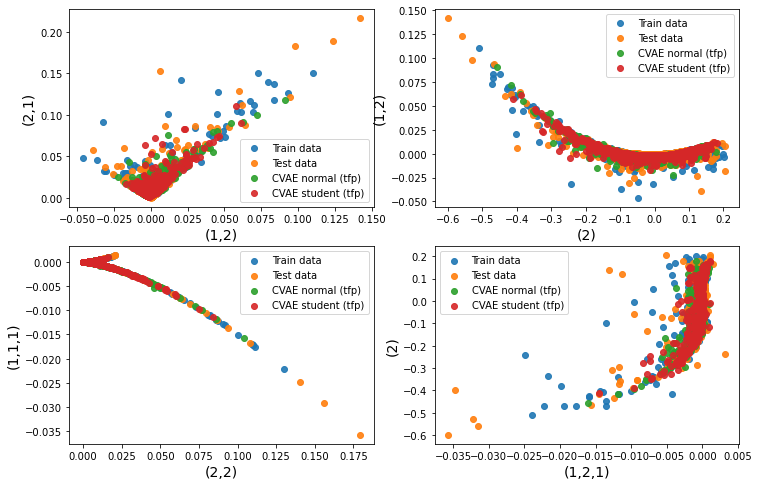

In [13]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]

set_sig = [train_sig, test_sig, generated_sig1, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

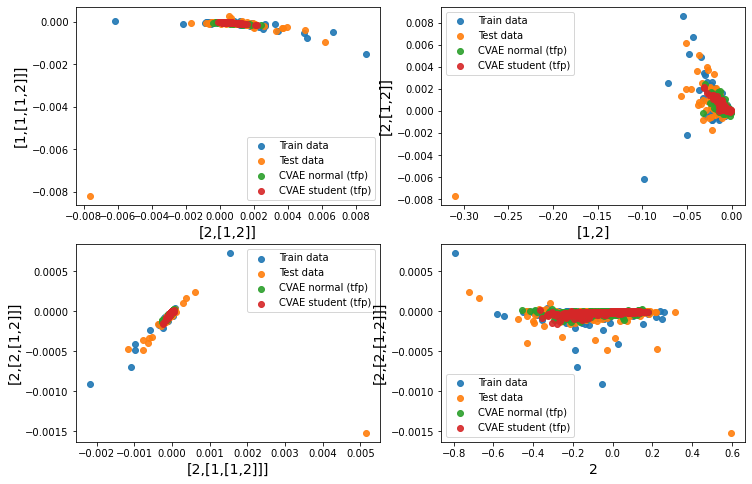

In [25]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig1, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Compared with keras and tfp

In [ ]:
# #CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])

In [ ]:
# # Standard normal (tfp)
# reload(cvae_tfp)
# sample_dim = data.shape[0]
# data_dim = data.shape[-1]
# cond_dim = data_cond.shape[-1]
# latent_dim = 8
# hidden_dim = 50
# weight = 0.003

# x_input = [data, data_cond]
# encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
# sampler = cvae_tfp.NormalSampler(latent_dim)
# encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
# decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
# model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
# model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
# model_normal.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

# normalised_generated1 = model_normal.generate(data_cond)
# generated_logsig1 = scaler.inverse_transform(normalised_generated1)
# generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

# # generated_sig1 = scaler.inverse_transform(normalised_generated1)
# # generated_logsig1 = np.array([tosig.sig2logsig(sig, 2, order) for sig in tqdm(generated_sig1)])

In [16]:
# mn, sd, z = generator.encoder([data, data_cond])
# x = generator.decoder([z, data_cond])

# data_torch = torch.tensor(data, dtype = torch.float)
# data_cond_torch = torch.tensor(data_cond, dtype = torch.float)
# x_torch = torch.tensor(x.numpy(), dtype = torch.float)
# mn_torch = torch.tensor(mn.numpy(), dtype = torch.float)
# sd_torch = torch.tensor(sd.numpy(), dtype = torch.float)

# loss = model.calculate_loss(data_torch, x_torch, mn_torch, sd_torch)
# loss/999

# model.eval()
# with torch.no_grad():
#     reconstructed_x, z_mu, z_var = model(data_torch, data_cond_torch)
#     loss = model.calculate_loss(data_torch, reconstructed_x, z_mu, z_var)
# loss/999

tensor(0.0105)

## Circle Data

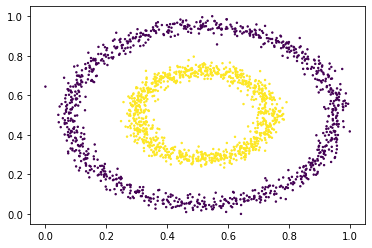

In [24]:
reload(cvae_torch)
BATCH_SIZE = 64         # number of data points in each batch
INPUT_DIM = 2     # size of each input
HIDDEN_DIM = 50        # hidden dimension   50
LATENT_DIM = 4         # latent vector dimension   8
CONDITION_DIM = 1      # condition dim
BETA = 0.02

data, data_cond = make_circles(n_samples=2000, noise=0.05, factor=0.5)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data_cond = data_cond.reshape(-1, 1)
# Plot dataset
plt.scatter(*data.T, c=data_cond, s=2)
plt.show()

In [25]:
train_iterator, test_iterator = cvae_torch.data_pepare(data,data_cond,1000, BATCH_SIZE)
model = cvae_torch.CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, CONDITION_DIM, BETA)
model.prepare(train_iterator, test_iterator)

In [26]:
model.train_all(1000)

Epoch 0, Train Loss: 2.10340, Test Loss: 2.01163
Epoch 1, Train Loss: 1.91969, Test Loss: 1.95853
Epoch 2, Train Loss: 1.86573, Test Loss: 1.93519
Epoch 3, Train Loss: 1.86426, Test Loss: 1.93304
Epoch 4, Train Loss: 1.85850, Test Loss: 1.92697
Epoch 5, Train Loss: 1.85323, Test Loss: 1.91915
Epoch 6, Train Loss: 1.84827, Test Loss: 1.89313
Epoch 7, Train Loss: 1.81481, Test Loss: 1.87937
Epoch 8, Train Loss: 1.77509, Test Loss: 1.84515
Epoch 9, Train Loss: 1.77194, Test Loss: 1.80728
Epoch 10, Train Loss: 1.68247, Test Loss: 1.74199
Epoch 11, Train Loss: 1.63092, Test Loss: 1.64860
Epoch 12, Train Loss: 1.56116, Test Loss: 1.54635
Epoch 13, Train Loss: 1.47709, Test Loss: 1.52089
Epoch 14, Train Loss: 1.44858, Test Loss: 1.46107
Epoch 15, Train Loss: 1.36718, Test Loss: 1.38983
Epoch 16, Train Loss: 1.34796, Test Loss: 1.31893
Epoch 17, Train Loss: 1.25653, Test Loss: 1.27296
Epoch 18, Train Loss: 1.25457, Test Loss: 1.23600
Epoch 19, Train Loss: 1.15942, Test Loss: 1.18632
Epoch 20, 

Epoch 165, Train Loss: 0.81757, Test Loss: 0.81248
Epoch 166, Train Loss: 0.78906, Test Loss: 0.80718
Epoch 167, Train Loss: 0.78960, Test Loss: 0.78334
Epoch 168, Train Loss: 0.81041, Test Loss: 0.80994
Epoch 169, Train Loss: 0.78962, Test Loss: 0.82167
Epoch 170, Train Loss: 0.79937, Test Loss: 0.81051
Epoch 171, Train Loss: 0.77479, Test Loss: 0.82582
Epoch 172, Train Loss: 0.80099, Test Loss: 0.79153
Epoch 173, Train Loss: 0.80451, Test Loss: 0.80062
Epoch 174, Train Loss: 0.79086, Test Loss: 0.80820
Epoch 175, Train Loss: 0.80400, Test Loss: 0.81096
Epoch 176, Train Loss: 0.79259, Test Loss: 0.80131
Epoch 177, Train Loss: 0.77038, Test Loss: 0.79739
Epoch 178, Train Loss: 0.78892, Test Loss: 0.78552
Epoch 179, Train Loss: 0.79467, Test Loss: 0.80266
Epoch 180, Train Loss: 0.80084, Test Loss: 0.77734
Epoch 181, Train Loss: 0.78472, Test Loss: 0.77399
Epoch 182, Train Loss: 0.78574, Test Loss: 0.79092
Epoch 183, Train Loss: 0.79592, Test Loss: 0.79910
Epoch 184, Train Loss: 0.78636,

Epoch 326, Train Loss: 0.75160, Test Loss: 0.75670
Epoch 327, Train Loss: 0.74666, Test Loss: 0.76835
Epoch 328, Train Loss: 0.74561, Test Loss: 0.76457
Epoch 329, Train Loss: 0.74531, Test Loss: 0.75950
Epoch 330, Train Loss: 0.71819, Test Loss: 0.74178
Epoch 331, Train Loss: 0.75054, Test Loss: 0.75130
Epoch 332, Train Loss: 0.76971, Test Loss: 0.75423
Epoch 333, Train Loss: 0.75189, Test Loss: 0.73591
Epoch 334, Train Loss: 0.73763, Test Loss: 0.74977
Epoch 335, Train Loss: 0.76139, Test Loss: 0.77451
Epoch 336, Train Loss: 0.73452, Test Loss: 0.76749
Epoch 337, Train Loss: 0.73724, Test Loss: 0.75051
Epoch 338, Train Loss: 0.74306, Test Loss: 0.76149
Epoch 339, Train Loss: 0.74215, Test Loss: 0.74767
Epoch 340, Train Loss: 0.72905, Test Loss: 0.75268
Epoch 341, Train Loss: 0.77279, Test Loss: 0.74864
Epoch 342, Train Loss: 0.75205, Test Loss: 0.74614
Epoch 343, Train Loss: 0.74492, Test Loss: 0.73354
Epoch 344, Train Loss: 0.73619, Test Loss: 0.78509
Epoch 345, Train Loss: 0.73013,

Epoch 489, Train Loss: 0.72249, Test Loss: 0.75501
Epoch 490, Train Loss: 0.71670, Test Loss: 0.74630
Epoch 491, Train Loss: 0.73782, Test Loss: 0.75411
Epoch 492, Train Loss: 0.73566, Test Loss: 0.75738
Epoch 493, Train Loss: 0.73832, Test Loss: 0.73239
Epoch 494, Train Loss: 0.74757, Test Loss: 0.75266
Epoch 495, Train Loss: 0.73357, Test Loss: 0.75378
Epoch 496, Train Loss: 0.73657, Test Loss: 0.74652
Epoch 497, Train Loss: 0.72388, Test Loss: 0.73898
Epoch 498, Train Loss: 0.72663, Test Loss: 0.74875
Epoch 499, Train Loss: 0.73944, Test Loss: 0.75428
Epoch 500, Train Loss: 0.74882, Test Loss: 0.75168
Epoch 501, Train Loss: 0.72694, Test Loss: 0.74539
Epoch 502, Train Loss: 0.72921, Test Loss: 0.74508
Epoch 503, Train Loss: 0.72226, Test Loss: 0.71861
Epoch 504, Train Loss: 0.73739, Test Loss: 0.74954
Epoch 505, Train Loss: 0.73682, Test Loss: 0.75593
Epoch 506, Train Loss: 0.73547, Test Loss: 0.73866
Epoch 507, Train Loss: 0.74406, Test Loss: 0.72814
Epoch 508, Train Loss: 0.71059,

Epoch 653, Train Loss: 0.73845, Test Loss: 0.74887
Epoch 654, Train Loss: 0.73787, Test Loss: 0.74078
Epoch 655, Train Loss: 0.73449, Test Loss: 0.76299
Epoch 656, Train Loss: 0.74075, Test Loss: 0.72491
Epoch 657, Train Loss: 0.73665, Test Loss: 0.73865
Epoch 658, Train Loss: 0.72596, Test Loss: 0.76437
Epoch 659, Train Loss: 0.73242, Test Loss: 0.72830
Epoch 660, Train Loss: 0.74531, Test Loss: 0.73526
Epoch 661, Train Loss: 0.73189, Test Loss: 0.73025
Epoch 662, Train Loss: 0.72025, Test Loss: 0.74202
Epoch 663, Train Loss: 0.72495, Test Loss: 0.74355
Epoch 664, Train Loss: 0.73716, Test Loss: 0.73827
Epoch 665, Train Loss: 0.72774, Test Loss: 0.72909
Epoch 666, Train Loss: 0.70920, Test Loss: 0.72409
Epoch 667, Train Loss: 0.72192, Test Loss: 0.73668
Epoch 668, Train Loss: 0.71557, Test Loss: 0.72874
Epoch 669, Train Loss: 0.71903, Test Loss: 0.72562
Epoch 670, Train Loss: 0.73785, Test Loss: 0.72369
Epoch 671, Train Loss: 0.70174, Test Loss: 0.74851
Epoch 672, Train Loss: 0.71663,

Epoch 818, Train Loss: 0.72726, Test Loss: 0.74055
Epoch 819, Train Loss: 0.74083, Test Loss: 0.74881
Epoch 820, Train Loss: 0.72255, Test Loss: 0.71486
Epoch 821, Train Loss: 0.73008, Test Loss: 0.74146
Epoch 822, Train Loss: 0.73785, Test Loss: 0.74719
Epoch 823, Train Loss: 0.72012, Test Loss: 0.73767
Epoch 824, Train Loss: 0.71114, Test Loss: 0.72545
Epoch 825, Train Loss: 0.72024, Test Loss: 0.70794
Epoch 826, Train Loss: 0.72010, Test Loss: 0.74269
Epoch 827, Train Loss: 0.72258, Test Loss: 0.72778
Epoch 828, Train Loss: 0.72353, Test Loss: 0.74060
Epoch 829, Train Loss: 0.71874, Test Loss: 0.74657
Epoch 830, Train Loss: 0.72387, Test Loss: 0.72822
Epoch 831, Train Loss: 0.73183, Test Loss: 0.73703
Epoch 832, Train Loss: 0.72234, Test Loss: 0.72912
Epoch 833, Train Loss: 0.71831, Test Loss: 0.73928
Epoch 834, Train Loss: 0.72385, Test Loss: 0.71410
Epoch 835, Train Loss: 0.73701, Test Loss: 0.73834
Epoch 836, Train Loss: 0.73325, Test Loss: 0.75174
Epoch 837, Train Loss: 0.72639,

Epoch 983, Train Loss: 0.70696, Test Loss: 0.75060
Epoch 984, Train Loss: 0.71589, Test Loss: 0.73797
Epoch 985, Train Loss: 0.71840, Test Loss: 0.72252
Epoch 986, Train Loss: 0.73321, Test Loss: 0.72712
Epoch 987, Train Loss: 0.73145, Test Loss: 0.73319
Epoch 988, Train Loss: 0.70416, Test Loss: 0.74636
Epoch 989, Train Loss: 0.71245, Test Loss: 0.73421
Epoch 990, Train Loss: 0.73959, Test Loss: 0.72875
Epoch 991, Train Loss: 0.71163, Test Loss: 0.73096
Epoch 992, Train Loss: 0.73423, Test Loss: 0.74743
Epoch 993, Train Loss: 0.71483, Test Loss: 0.71657
Epoch 994, Train Loss: 0.74021, Test Loss: 0.74044
Epoch 995, Train Loss: 0.73078, Test Loss: 0.75263
Epoch 996, Train Loss: 0.73597, Test Loss: 0.72150
Epoch 997, Train Loss: 0.71351, Test Loss: 0.72619
Epoch 998, Train Loss: 0.72809, Test Loss: 0.74484
Epoch 999, Train Loss: 0.72111, Test Loss: 0.74234


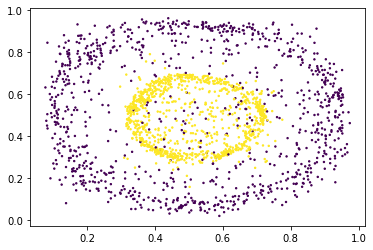

In [27]:
cond = torch.randint(0, 2, (2000, 1)).to(dtype=torch.long)
points = model.generate(cond)
plt.figure()
plt.scatter(*points.T, c=cond, s=2)
plt.show()